# Plotting Tools & Images
Some basic plotting tools used throughout the notebook are generated below. Sample images are extracted from the project video.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Plot 2 images side-by-side
def plot_sbs(img1, img2, cmap1 = 'brg', cmap2 = 'brg'):
    
    plt.figure(figsize = (16, 20))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap1)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap2)

    
def plot_imgs(X, title=[], cols = 2, cmap='brg', h_mult = 3):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    plotNum = 1
    plt.figure(figsize = (16, num_rows*h_mult))
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(X[i], cmap=cmap)
        if(title):
            plt.title(title[i])
        plotNum = plotNum + 1

In [2]:
# Clip some images from the project video for testing throughout the notebook

from moviepy.editor import VideoFileClip

# Times for frames to extract
times = np.arange(0,50,5)

clip1 = VideoFileClip("project_video.mp4")

raw_imgs = []

for time in times:
    raw_imgs.append(clip1.get_frame(time))
    

# Camera Calibration
Camera calibration is performed in this section using chessboard images and OpenCV libaries. 

It's assumed that the chessboard is oriented on the x-y plane in the real world, such that the z coordinate of any point on the board is 0. The "corners" of the board in this case are where 4 adjacent tiles meet (2 white and 2 black), which excludes areas along the edge of the image. In this case, the "real world" coordinates of such corners are just assigned integer values (i.e.: they're not actually measured), since they are all equally spaced. 

The OpenCV function "findChessboardCorners" is used to find the corners in each of the images. Images are only used in calibration if all of the  chessboard corners are found; otherwise, they are excluded. 

Once points in the images have been correlated with points in the real world, their respective coordinates are passed to the OpenCV "calibrateCamera" function, which creates a matrix that can be used to undistort any images taken with the same camera using the OpenCV "undistort" function.

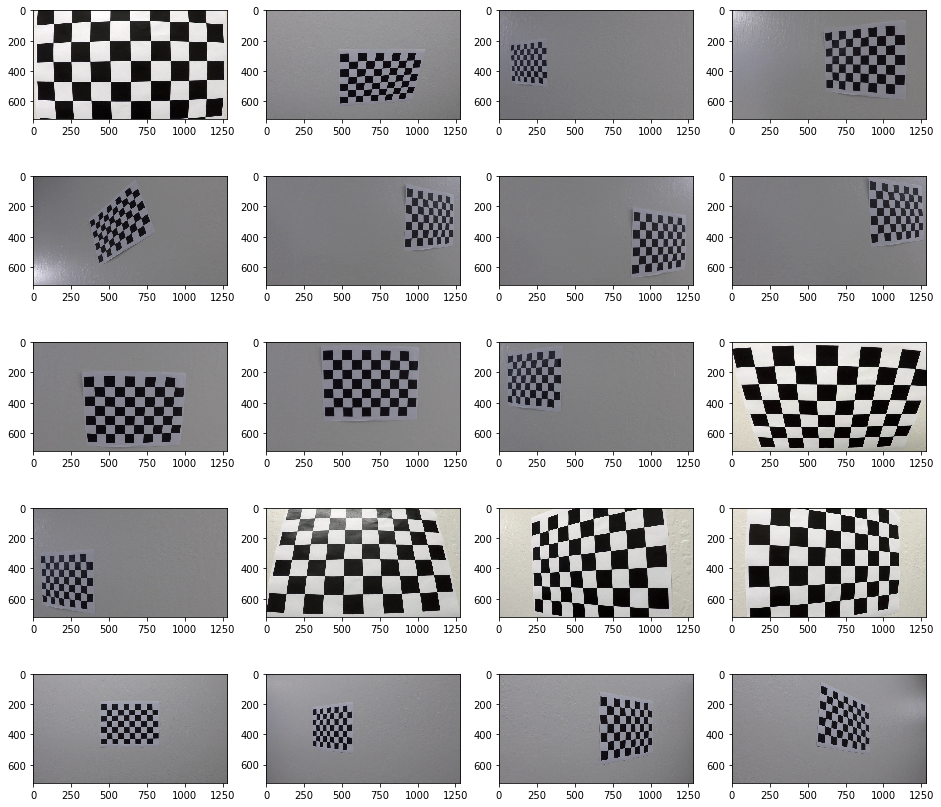

In [3]:
import glob

# Read cameral calibration images
cal_files = glob.glob('camera_cal/*.jpg')
cal_imgs = []
for file in cal_files:
    cal_imgs.append(mpimg.imread(file)) #RGB image
    
plot_imgs(cal_imgs, cols = 4, h_mult = 3)

In [4]:
import cv2
import pickle

def cal_camera(imgs, nc = (9,6), plots = False):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nc[0]*nc[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:nc[0], 0:nc[1]].T.reshape(-1,2)
    
    shape = imgs[0].shape[1::-1]
    
    for img in imgs:
        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, nc, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #img = cv2.drawChessboardCorners(img, nc, corners, ret)
            #plt.figure()
            #plt.imshow(img)
    
    retval, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    return matrix, distortion



save_mtx = 'camera_cal/cam_cal_mtx.p'
save_dist = 'camera_cal/cam_cal_dist.p'

action = 'gen'

if(action == 'gen'):
    UNDIST_MTRX, UNDIST_DIST = cal_camera(cal_imgs)
    pickle.dump(UNDIST_MTRX, open(save_mtx, "wb" ))
    pickle.dump(UNDIST_DIST, open(save_dist, "wb" ))
elif(action == 'load'):
    with open(save_mtx, mode='rb') as f:
        mtx = pickle.load(f)
    with open(save_dist, mode='rb') as f:
        dist = pickle.load(f)
else:
    print("Choose whether to generate or load camera calibration data.")


# Undistort Images
Here, an undistory utility using the the OpenCV "undistort" function is created. A side-by-side comparison of one of the raw and undistorted chessboard images shown below provides the best illustration of undistortion. A test image from the video is also shown for comparison, though it's a little tougher to make out the difference; it's most noticable along the hood of the car at the bottom corners of the image. 

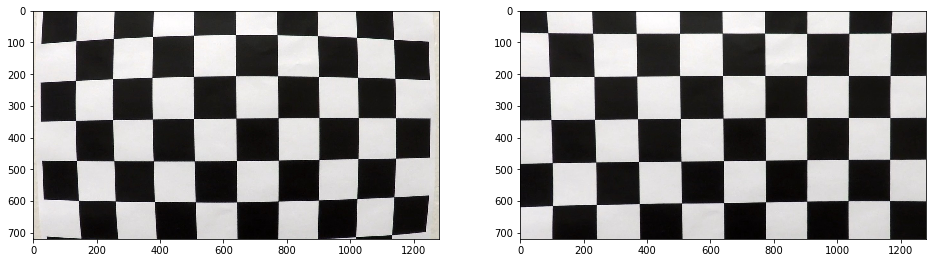

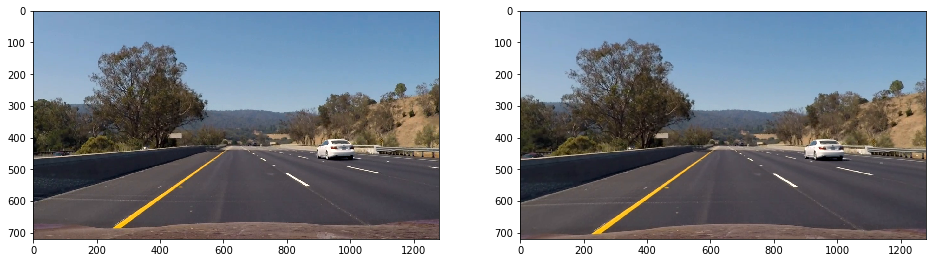

In [5]:
# Undistort utility function
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Undistorted chessboard
undist_chessboard = undistort(cal_imgs[0], UNDIST_MTRX, UNDIST_DIST)
plot_sbs(cal_imgs[0], undist_chessboard)

#Undistort our test images
undist_imgs = []
for img in raw_imgs:
    undist_imgs.append(undistort(img, UNDIST_MTRX, UNDIST_DIST))
plot_sbs(raw_imgs[4], undist_imgs[4])

# Thresholding
To pick out lane lines, I tested several different combinations of sobel thresholding (magnitude, direction, etc) and color thresholding (red and HLS colorspaces) as covered in the Udacity classroom sessions. However, for the project video, I found that my trusty old HSV color selection utitliy - developed in the first project of this course and found [here](https://github.com/jjw2/SDC_Term1_P1.git) - worked great on its own! 

Essentially, this function converts the subject image to the [HSV color space](https://www.lifewire.com/what-is-hsv-in-design-1078068), and applies a filter on each of these channels to isolate yellow and white colors. It even does a decent job of picking out the lane lines on the concrete portions of the road, which is, obviously, where finding the lane lines is the hardest.

Examples of thresholding are shown below side-by-side.

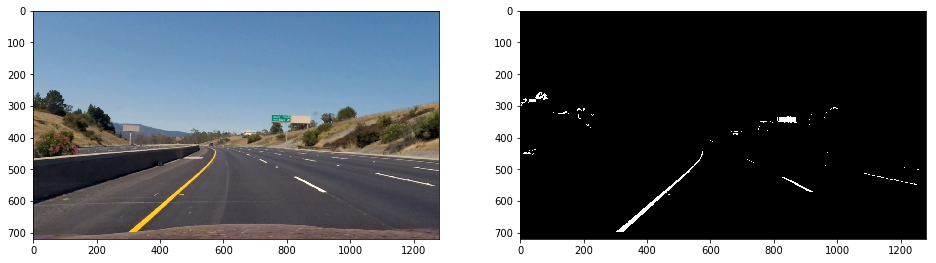

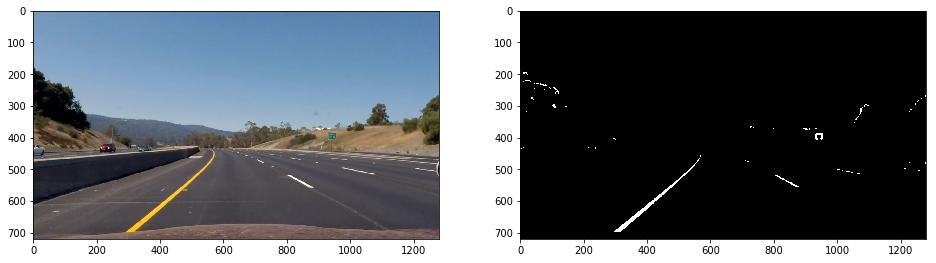

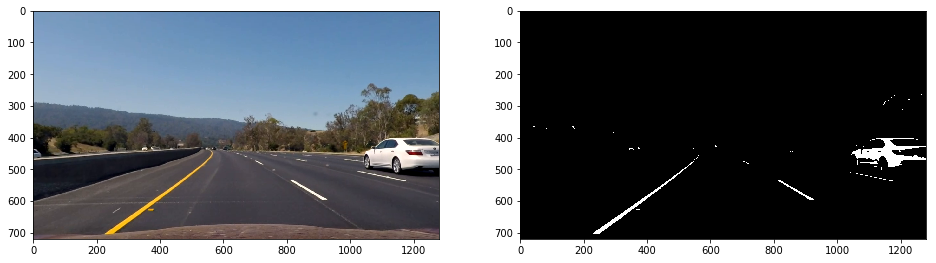

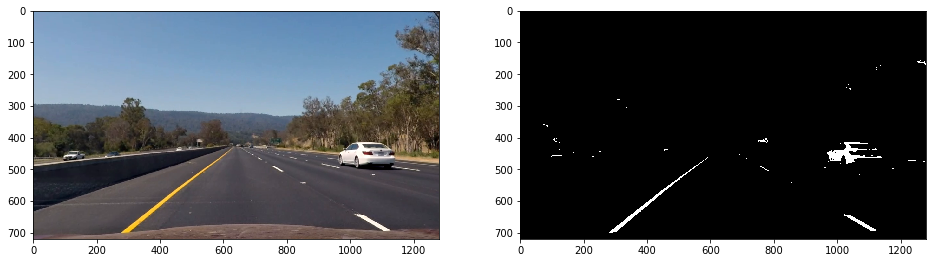

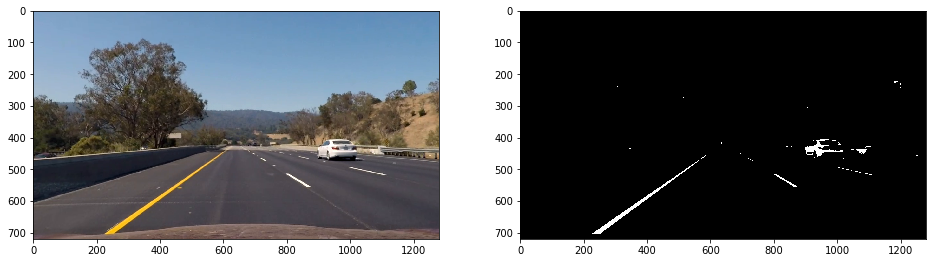

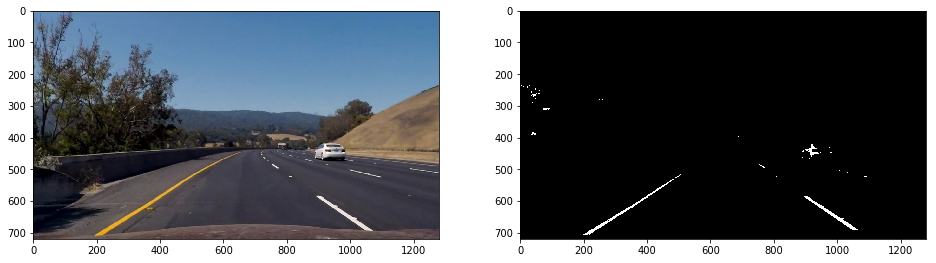

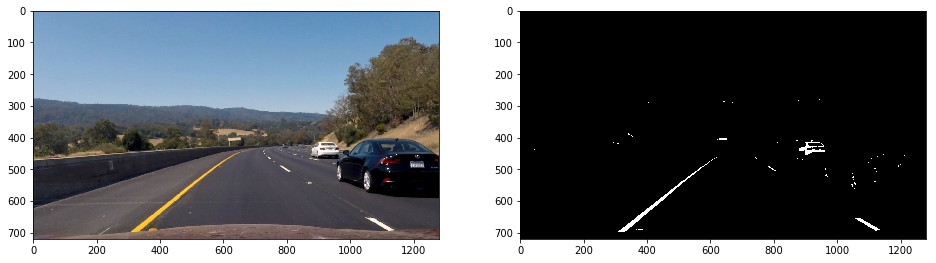

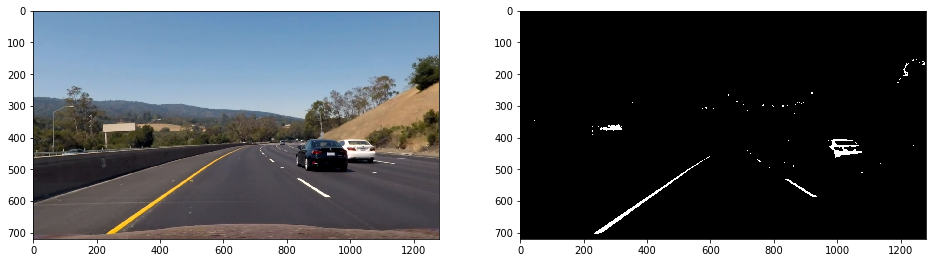

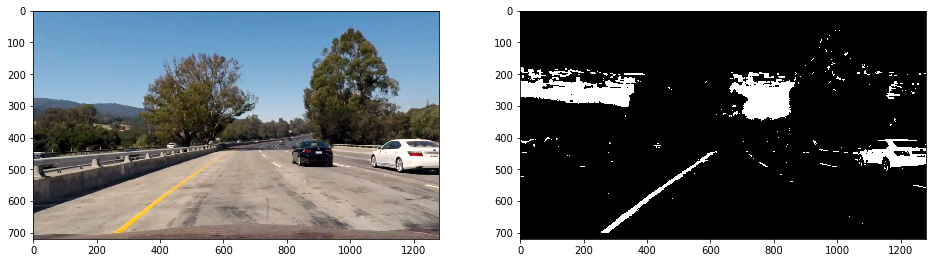

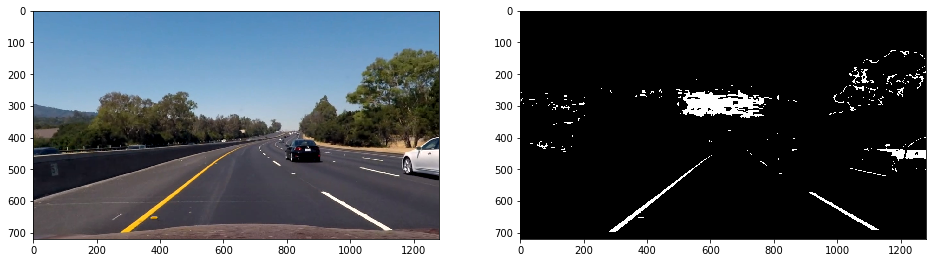

In [6]:

# Sobel thresholding
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Sobel magnitude thresholding
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Sobel direction thresholding
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

# HLS color thresholding
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


# HSV color thresholding
def hsv_select(img, color1_lower, color1_upper, color2_lower, color2_upper):
    #Convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Generate masks
    mask2 = cv2.inRange(hsv, color2_lower, color2_upper)
    mask1 = cv2.inRange(hsv, color1_lower, color1_upper)
    
    # Apply mask to original image
    mask = cv2.bitwise_or(mask1, mask2)
    
    binary_output = np.zeros_like(mask).astype(np.uint8)
    binary_output[mask>0] = 1; # convert to 0-1
    
    return binary_output

# Red color selection/thresholding
def red_select(img, thresh=(0,255)):
    red = img[:,:,0]
    binary_output = np.zeros_like(red)
    binary_output[(red > thresh[0]) & (red <= thresh[1])] = 1
    return binary_output


# Thresholding function that applies the best variation of thresholding sub-functions above
def thresh_fcn(img, ksize=5, xythresh=(20,100), magthresh=(10,100), 
               dirthresh=(0.6, 1.0), redthresh=(170,255), hlsthresh=(80,255), plot = False):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    """ ## Commented out to improve performance
    # X gradient
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xythresh)
    if plot:
        plt.figure()
        plt.imshow(gradx, cmap='gray')
        plt.title('X Grad')
    
    # Y gradient
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=xythresh)
    if plot:
        plt.figure()
        plt.imshow(grady, cmap='gray')
        plt.title('Y Grad')
    
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    if plot:
        plt.figure()
        plt.imshow(mag_binary, cmap='gray')
        plt.title('Grad Magnitude')
    
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=dirthresh)
    if plot:
        plt.figure()
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Grad Dir')
    
    red_binary = red_select(img, thresh=redthresh)
    if plot:
        plt.figure()
        plt.imshow(red_binary, cmap='gray')
        plt.title('Red')
    
    hls_binary = hls_select(img, thresh=hlsthresh)
    if plot:
        plt.figure()
        plt.imshow(hls_binary, cmap='gray')
        plt.title('HLS')
    """
    
    # Define yellow and white colors for used in color selection
    lower_yellow = np.array([40, 40, 40])
    upper_yellow = np.array([80, 255, 255])
    lower_white = np.array([0, 0, 215])
    upper_white = np.array([255, 255, 255])
    hsv_binary = hsv_select(img, lower_yellow, upper_yellow, lower_white, upper_white)
    if plot:
        plt.figure()
        plt.imshow(hsv_binary, cmap='gray')
        plt.title('HSV Select')

    newimg = np.zeros_like(img[:,:,0])
    
    # Variations on thresholding using different binaries
    #newimg[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    #newimg[((gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    #newimg[ (red_binary == 1) & (hls_binary == 1)] = 1
    
    # In the end, HSV color selection alone seemed to do the trick.
    newimg[(hsv_binary == 1)] = 1
    
    return newimg

thresh_imgs = []
for i in range(len(undist_imgs)): #undist_imgs
    thresh_imgs.append(thresh_fcn(undist_imgs[i], plot=False))
    plot_sbs(undist_imgs[i], thresh_imgs[i], cmap2 = 'gray')

    

# Perspective Transform
In this section, a perspective transform is performed to obtain a top-down view of the road surface for use in lane tracking. The perspective transform was completed using the OpenCV "getPerspectiveTransform" and "warpPerspective" functions. 

First, an image containing straight lane lines was selected - in this case, from the example images provided, since the project video didn't contain sections where the car was centered in the lane and the lane lines were straight. The image was first undistorted, and then source points for use in the perspective transform were selected by hand. The image and points are shown below.

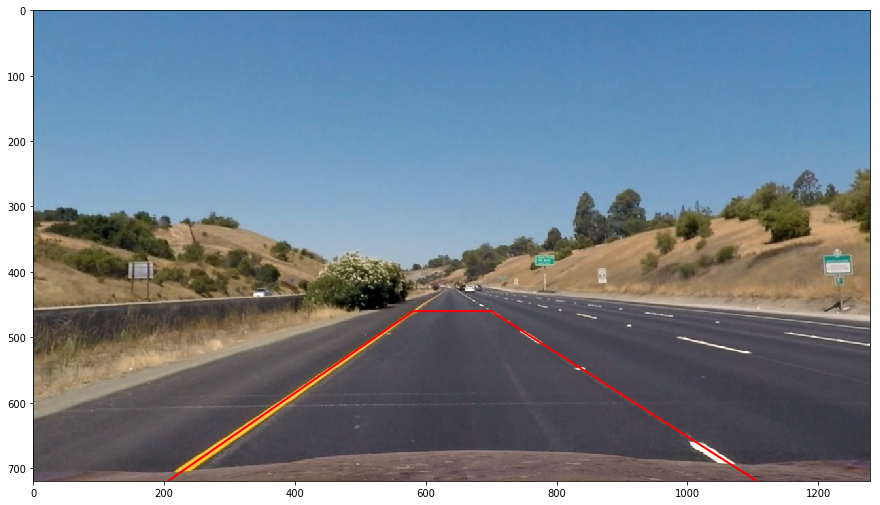

In [7]:
# Grab an image to use for calibrating the perspective warp
strt_img = mpimg.imread('test_images/straight_lines1.jpg')
strt_img = undistort(strt_img, UNDIST_MTRX, UNDIST_DIST)
shp = strt_img.shape

# Pick out some points from the image - these were fine-tuned by hand
xpnts = [207, 581, 700, 1105]
ypnts = [shp[0]-1, 460, 460, shp[0]-1,]

# Plot points
plt.figure(figsize = (15,25));
plt.imshow(strt_img);
plt.plot(xpnts, ypnts, 'r-', linewidth=2);


Second, destination points were chosen; these points map the region of the source image to be transformed, and where that region will be located in the destination image. OpenCV getPerspectiveTransform takes source and destination points and creates a transform matrix that can be used with the warpPerspective function to transform an image; note that it can also be inverted and used to unwarp an image. The image below shows the result of the perspective transform/warp.

(0, 1280)

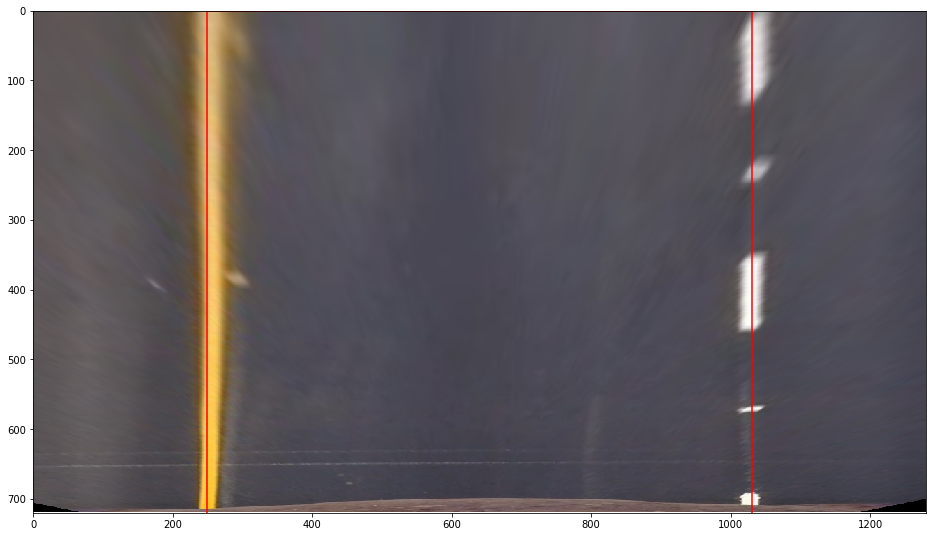

In [8]:
# Define a warping function to do the perspective transform
# Reshape to the format required by cv2
srcx = np.array(xpnts)[np.newaxis].T
srcy = np.array(ypnts)[np.newaxis].T
src = np.concatenate((srcx, srcy), axis=1).astype(np.float32)

ofst = 250 #offset from the side of the screen; needs to be large enough to capture curved lines
dstxpnts = [ofst, ofst, shp[1]-ofst, shp[1]-ofst]
dstypnts = [shp[0], 0, 0, shp[0]]
dstx = np.array(dstxpnts)[np.newaxis].T
dsty = np.array(dstypnts)[np.newaxis].T
dst = np.concatenate((dstx, dsty), axis=1).astype(np.float32)

# Get warp matrix
WARP_MTRX = cv2.getPerspectiveTransform(src,dst)

# Warping utility function
def warpPers(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

plt.figure(figsize=(16, 24));

warped_img = warpPers(strt_img, WARP_MTRX);
plt.imshow(warped_img);
plt.plot(dstxpnts, dstypnts, 'r-')
plt.ylim(720, 0)
plt.xlim(0,1280)

The image below shows the result of warping on the thresholded test images (original on the left, warped on the right).The concrete sections don't look great, but it appears that we should be able to fit a polynomial to the thresholded points (coming in later sections). 

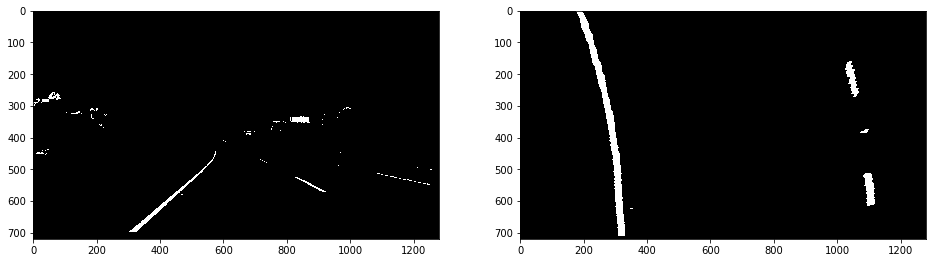

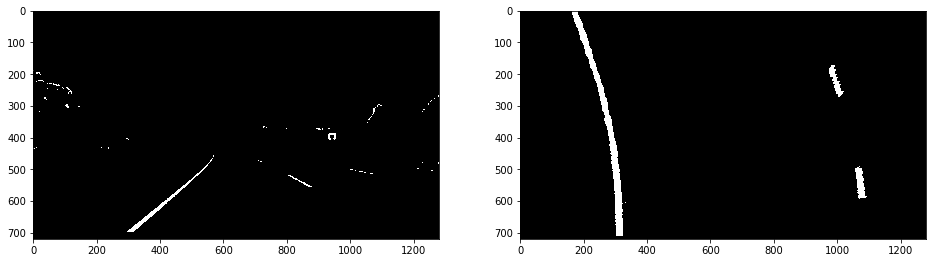

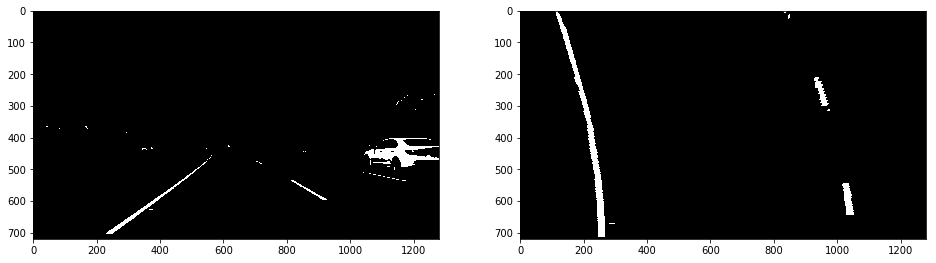

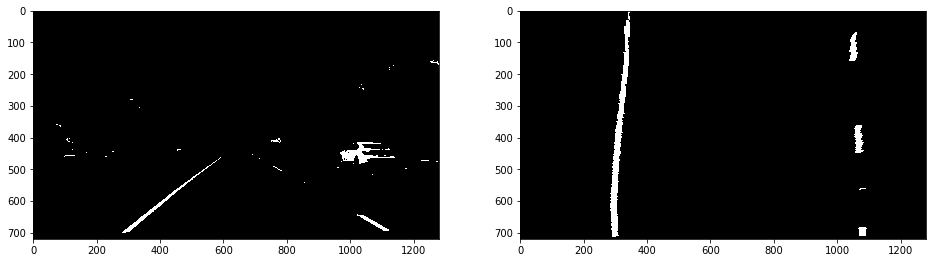

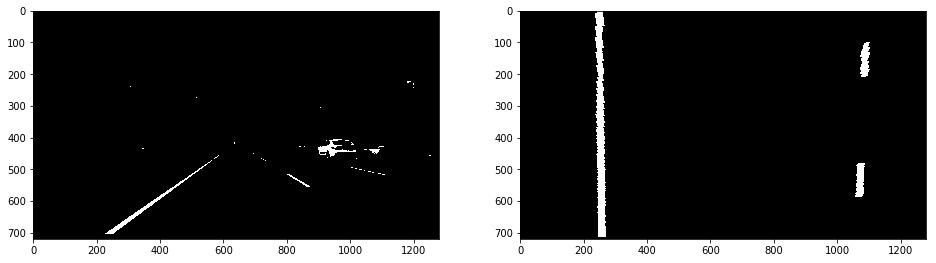

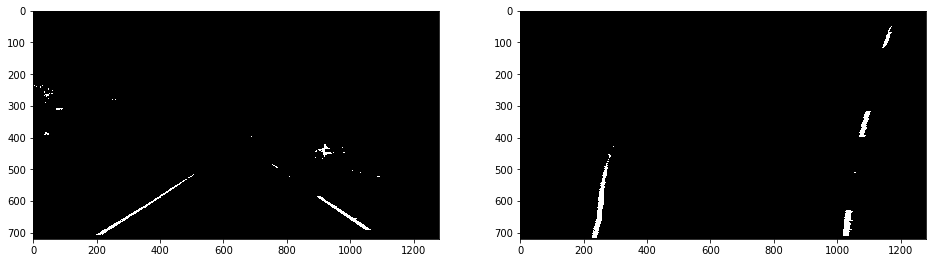

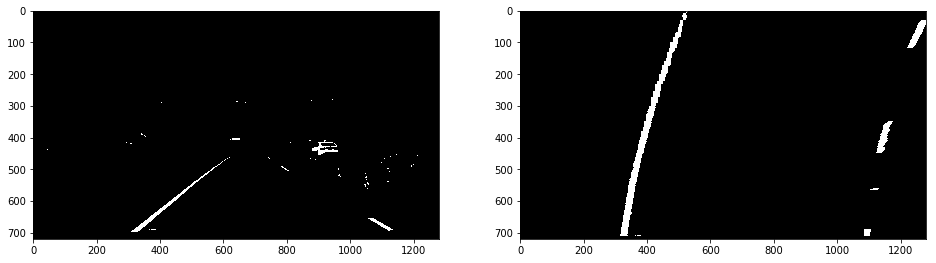

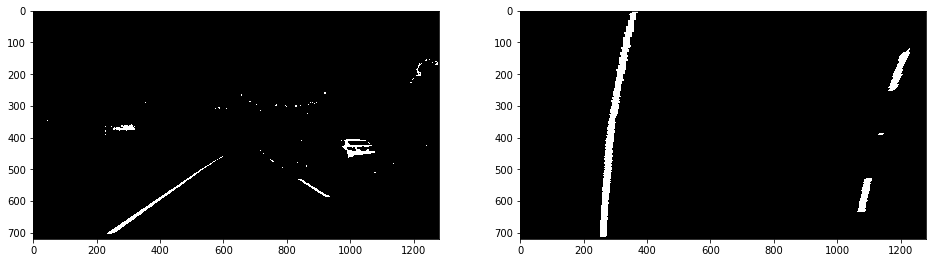

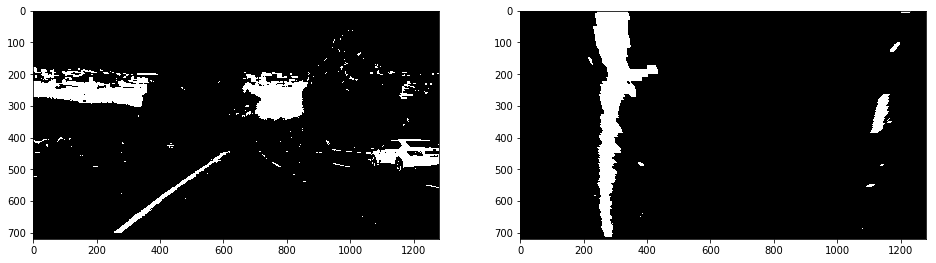

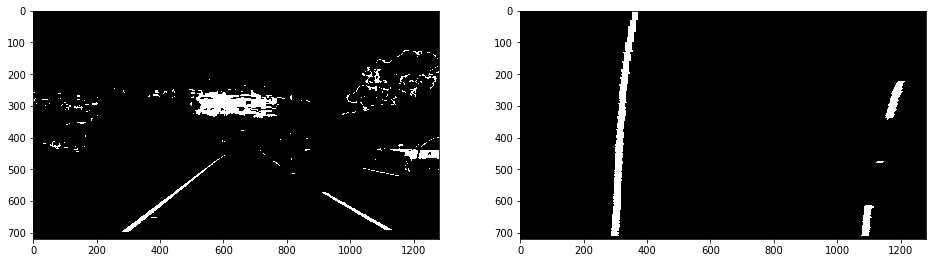

In [9]:
# Apply warping to test images.
warp_imgs = []
for img in thresh_imgs:
    warp_imgs.append(warpPers(img, WARP_MTRX))
    plot_sbs(img, warp_imgs[-1], cmap1='gray', cmap2='gray')
    


# Finding Lane Lines

The next step of the process is finding the lane lines in the thresholded images.

First, a histogram of the pixels in the images was generated. In this case, only the bottom half of the images were used (i.e.: the half of the image closest to the car). The images below show the histogram result for one of the sample images.

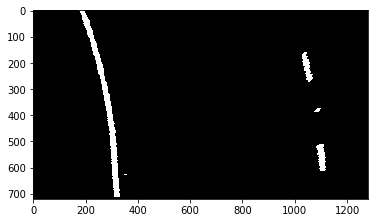

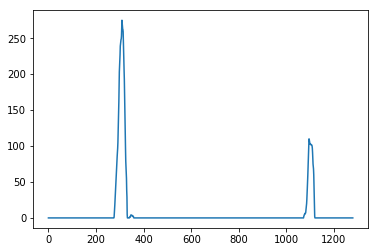

In [10]:
# Select a single image for some testing
test_idx = 0


def lane_hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

plt.imshow(warp_imgs[test_idx], cmap='gray')
plt.figure()
plt.plot(lane_hist(warp_imgs[test_idx]))


Next, a sliding window technique was used to capture the (x,y) points that make up each lane line. The technique searches for pixels within a series of small "windows" that each make up a sub-section of the image. In this case, the first sliding window is centered on x location of the two peaks in the historgram (based on the assumption that the peak in the left half of the histogram is associated with the left lane, and the peak in the right half of the histogram is associated with the right lane). Subsequent sliding windows - which move from the bottom of the image to the top with each iteration - are located based on the average x location of the pixels found in the previous window. 

Once the sliding window technique has identified the pixels associated with each lane, a polynomial fitting function is used to apply a second order polynomial fit to the pixels that describes the lane line. 

An image of the sliding windows and the resulting polynomials for one of our sample images is shown below.

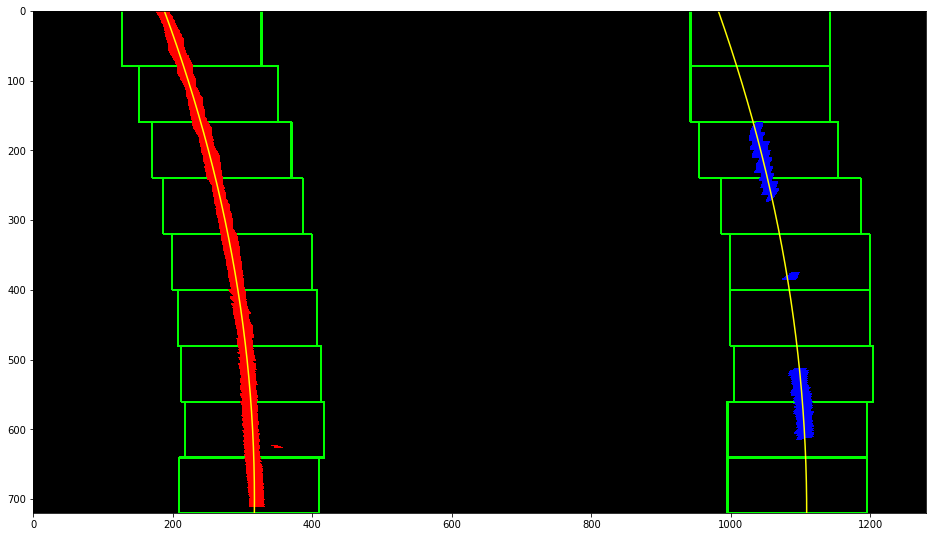

In [11]:
# This function should operate in pixel space, since it's dealing directly with images
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = lane_hist(img)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    l_windows = 0
    r_windows = 0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            l_windows = l_windows+1
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            r_windows = r_windows+1

    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    # "confidnce" of the results -> needs some work above
    l_conf = l_windows/nwindows
    r_conf = r_windows/nwindows
    
    return leftx, lefty, l_conf, rightx, righty, r_conf, out_img


# Fit a polynomical to x and y data
def fit_polynomial(x, y):
    success = False
    fit = np.polyfit(y, x, 2)
   
    # if list are empty, we didn't get a fit
    if fit.size:
        success = True
    
    return fit, success
    
# Evaluate polynomial at given y values    
def eval_poly(fit, yvals):
    val = fit[0]*yvals**2 + fit[1]*yvals + fit[2]
    return val


def color_lines(img, x, y, color = (255,0,0)):
    img[y,x] = color
    return img

leftx, lefty, l_conf, rightx, righty, r_conf, out_img = find_lane_pixels(warp_imgs[test_idx])
left_fit, s = fit_polynomial(leftx, lefty)
right_fit, s = fit_polynomial(rightx, righty)

thisImg = warp_imgs[test_idx]
ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

# Plots the left and right polynomials on the lane lines
plt.figure(figsize = (16,20))
plt.plot(eval_poly(left_fit, ploty), ploty, color='yellow')
plt.plot(eval_poly(right_fit, ploty), ploty, color='yellow')
color_lines(out_img, leftx, lefty)
color_lines(out_img, rightx, righty, (0,0,255))
plt.imshow(out_img)


The sliding window technique works well for finding lane lines in any single image, but given that this system is finding lane lines in many successive images taken in rapid succession (i.e.: a video...), the sliding window technique - being relatively computationally expensive - doesn't have to be used on each image. The pipeline can be optimized such that, if a polynomial fit exists from a previous iteration of lane finding, a search can be performed in a region around the last known value of each lane line. Of course, this is based on the assumption that the lane lines aren't going to be moving drastically in each successive frame of the video. 

The function below implements a pixel search within a window around a previous polynomial fit, and the figure below illustrates the search window (in green) the found pixels (in color) and the resulting polynomial fit for a sample image. Note that the sample image in this case is simply the same image on which the pixel search was perfromed above, but the intent here is simply to illustrate the process.

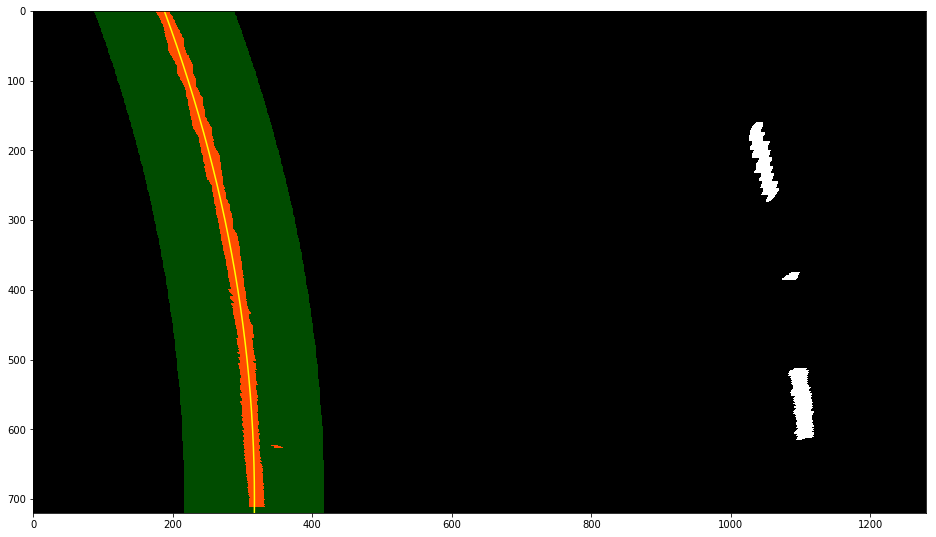

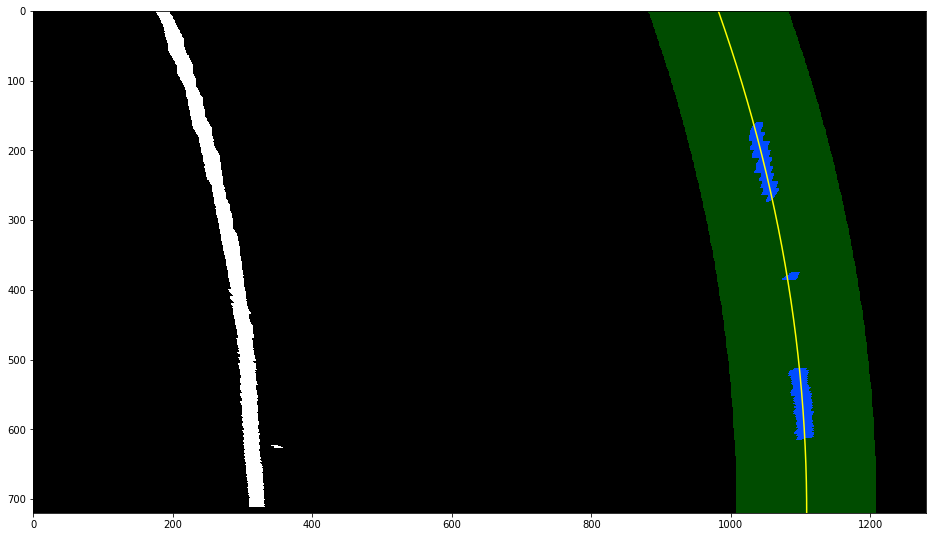

In [12]:
# Pixel space
def search_around_poly(img, fit_prev):
    # Width of search window
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    lane_inds = ((nonzerox > (fit_prev[0]*(nonzeroy**2) + fit_prev[1]*nonzeroy + 
                    fit_prev[2] - margin)) & (nonzerox < (fit_prev[0]*(nonzeroy**2) + 
                    fit_prev[1]*nonzeroy + fit_prev[2] + margin)))

    # Again, extract left and right line pixel positions
    xpnts = nonzerox[lane_inds]
    ypnts = nonzeroy[lane_inds] 

    # Fit new polynomials
    fit_new, s = fit_polynomial(xpnts, ypnts)
    
    return fit_new, xpnts, ypnts, s
    

# Function intended only for plotting search window
def plot_srch_poly(img, fit_prev, fit_new, xpnts, ypnts, color=(0,0,255)):
    
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitx_prev = eval_poly(fit_prev, ploty)
    line_window1 = np.array([np.transpose(np.vstack([fitx_prev-margin, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx_prev+margin, ploty])))])
    line_pts = np.hstack((line_window1, line_window2))

    out_img[ypnts, xpnts] = color
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.figure(figsize=(16,10))
    plt.imshow(result)
    plt.plot(eval_poly(fit_new, ploty), ploty, color='yellow')



left_fit_new, leftx, lefty, s = search_around_poly(warp_imgs[test_idx], left_fit)
right_fit_new, rightx, righty, s = search_around_poly(warp_imgs[test_idx], right_fit)

plot_srch_poly(thisImg, left_fit, left_fit_new, leftx, lefty, (255,0,0))
plot_srch_poly(thisImg, right_fit, right_fit_new, rightx, righty)




# Calculate Curvature

Once polynomials have been fitted to lane lines, curvature can be calculated. The calc_curv function uses a standard formula for calculating curvature of 2nd order polynomials. Note however, that we care about curvature in the real world. As a result, the polynomial fits that have been calculated must be converted into real-world coordinates. The calc_curv function performs this conversion using conversion factors - the number of meters per pixel in the perspective-transformed images above - that were calculated by hand based on known quantities -> the width of the lane, and the length of the dashed right lane line.

Since curvature changes along the polynomial, the point at which curvature will be calculated must also be provided. In this case, since the calc_curv function operates in real world coordinates, it expects a value in meteres, starting from the top of the perspective-transformed images. Here, I'll be using a value of 20m, which is roughly the length of the segment of road shown in the perspective-transformed images (i.e.: calculating curvature at the position of the vehicle).

In [13]:
# Define conversion from pixel space to world space - taken from measurements from sample images
MPX = 3.7/780
MPY = 3.048/80
CURV_LOC = 20 # 20m from top of images

# Calculate curvature in world space
def calc_curv(y_val, fit, mpx, mpy):
    # Convert fit polynomial from pixel space to world space
    fit_m = fit*[mpx/(mpy**2), mpx/mpy, mpx] #3rd value doesn't matter because it doesn't get used...
    curv = ((1 + (2.0*fit_m[0]*y_val + fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
    
    return curv

l_curv = calc_curv(CURV_LOC, left_fit, MPX, MPY)
r_curv = calc_curv(CURV_LOC, right_fit, MPX, MPY)
print("Left: ", l_curv, "   Right: ", r_curv)

Left:  580.848773923    Right:  624.0426018


# Project to the Road

Now that the lane has been identified and lane lines have been found, we can project the lane back onto the road in the original image. In this case, the OpenCV fillPoly function is used to fill in the lane between the left and right lane line polynomials, and the inverted perspective transform matrix is used to project the lane back down onto the image of the road. An example image is shown below.

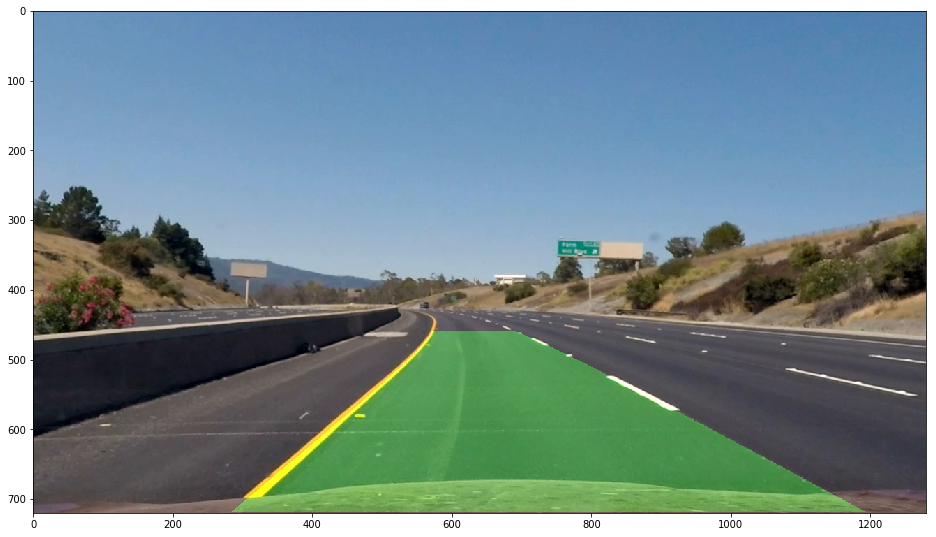

In [14]:
def plot_lane(undist_img, warped_img, M, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (undist_img.shape[1], undist_img.shape[0]), flags=cv2.WARP_INVERSE_MAP) 
    # Combine the result with the original image
    out_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return out_img


plt.figure(figsize=(16,20))
left_fitx = eval_poly(left_fit, ploty)
right_fitx = eval_poly(right_fit, ploty)
plt.imshow(plot_lane(undist_imgs[test_idx], warp_imgs[test_idx], WARP_MTRX, left_fitx, right_fitx, ploty))


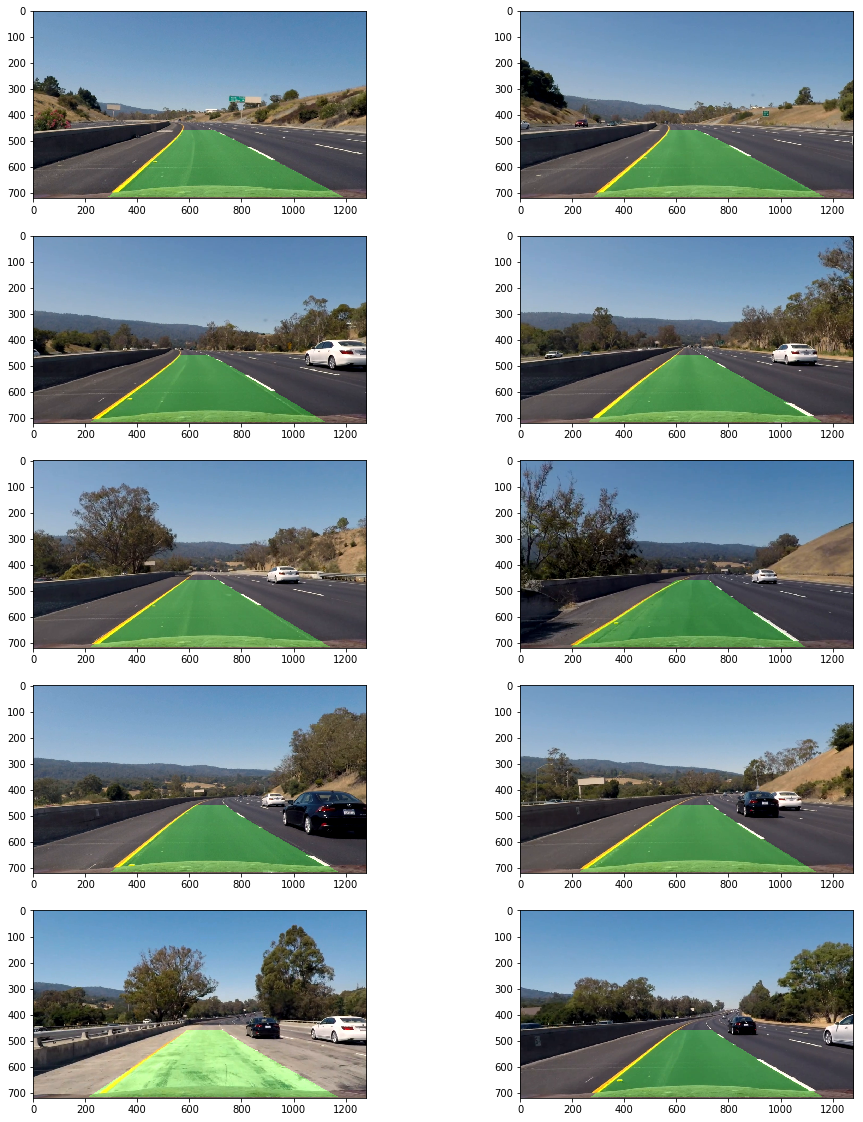

In [15]:
lane_imgs = []
for idx in range(len(warp_imgs)):
    leftx, lefty, left_conf, rightx, righty, right_conf, out_img = find_lane_pixels(warp_imgs[idx])
    left_fit, s = fit_polynomial(leftx, lefty)
    right_fit, s = fit_polynomial(rightx, righty)
    l_curv = calc_curv(150, left_fit, MPX, MPY)
    r_curv = calc_curv(150, right_fit, MPX, MPY)
    left_fitx = eval_poly(left_fit, ploty)
    right_fitx = eval_poly(right_fit, ploty)
    lane_imgs.append(plot_lane(undist_imgs[idx], warp_imgs[idx], WARP_MTRX, left_fitx, right_fitx, ploty))

plot_imgs(lane_imgs, h_mult = 4)

# Lane and Position Tracking

The functions above all handle finding lane lines in a single image. Given that we're tracking lane lines in a video, we can use information from successive images to help smooth out our lane projections/estimates and also deal with cases where we're not able to detect lane lines in a given frame. In order to track lane lines over time, classes were created to processand store information. 

A Line class was created to process store information about each lane line:
- polynomial fit, with history
- curvature values
- x positions of the lane lines at the bottom of the image, with history
- status of the fit for the line (failure, etc)

A LaneInfo class was created to store information specific to the lane:
- curvature, with history
    - each curvature entry in the history is assumed to be the average of the curvatures of the two lines
- center line offset, with history
    - the offset is calculated based on the difference between the center of the image and the point in the middle of the average x values (at the bottom of the image) of the left and right lines.

Within the LaneInfo class, the values of lane curvature and center line offset are rate limited, and a maximum limit is put on . This was done for a couple reasons:
1. to smooth the output values for curvature and lane offset, so that they're a little easier to read in the video (otherwise, then can jump around a lot from loop to loop, making the values difficult to read)
2. radius of curvature goes to infinity as the road straightens out; putting a cap on the radius of curvature (at 10 km in this case) also makes the values easier to read, and allows for the rate limiting above (i.e.: it would be difficult to rate limit the values if they were going to infinity, as they could "wind up," which would result in large errors when transitioning from a straight road (infinite radisu of curvature) to a curved road.

See the comments in each of these classes for more information.

In [21]:
class Line():
    # length of historical info
    hist_buff_size = 5
    # allowable change in fit to consider fit successful
    fit_change_rate = [0.05, .5, 100.0]
    # number of successive
    fail_thresh = 5 
    # y value used for curvature calculation in meters - bottom of screen
    curv_yval = 19.6
    # polynomial evaluation y value (for lane position at bottom of image)
    poly_yval = 720
    
    def __init__(self):
        # iteration counter
        self.iter = 0
        # has fit failed for n iterations?
        self.fail = True
        # failure counter
        self.fail_cntr = 0
        # failure frames - stores which frames failed in the video
        self.fail_frames = []
        # x values (bottom of image) of the last n fits of the line
        self.x_hist = [] 
        # average x values of the fitted line over the last n iterations
        self.x_best = None     
        # polynomial coefficients averaged over the last n iterations
        self.fit_best = np.float32([0, 0, 0])  
        # polynomial coefficients for the most recent fit
        self.fit_this = np.float32([None])
        # polynomical coefficient history for the last n ierations
        self.fit_hist = np.array([[0, 0, 0]])
        #radius of curvature of the line in meters
        self.curv = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels - could be used for plotting but not used at the moment
        self.allx = None
        #y values for detected line pixels - could be used for plotting but not used at the moment
        self.ally = None
    
    # increment iteration
    def incr(self):
        self.iter = self.iter+1
    
    
    # Evaluate the value of the polynomial (best fit) at a given y position, in meters
    def eval_poly(self, ypnts):
        fit = self.fit_best
        return fit[0]*ypnts**2 + fit[1]*ypnts + fit[2]
    
    
    # Check the polynomial fit against success/failure criteria
    def check_fit(self, fit):
        if(self.fit_this is not None):
            fit_diff = fit-self.fit_this #fit_this is last fit
            rate = self.fit_change_rate

            # Check that the fit hasn't changed too much.
            # However, if we've failed (i.e.: haven't fit for several frames) we can't run this check
            # and we need to allow the fit to pass, because our fit history is out of dat
            if(self.fail == False and 
               ((abs(fit_diff[0]) > rate[0]) or 
                (abs(fit_diff[1]) > rate[1]) or 
                (abs(fit_diff[2]) > rate[2]))):
                print("Fit diff exceeded")
                return False
            else:
                return True
        else:
            return True #if this is our first fit, we're forced to take it.
    
    
    # Push a fit into the fit history buffer
    def push_fit(self, fit):
        self.fit_this = np.array(fit)
        
        # first push
        if(np.array_equal(self.fit_hist[0], np.float32([0,0,0]))):
            self.fit_hist = self.fit_this
            self.fit_hist = np.expand_dims(self.fit_hist, axis=0)
        else:
            self.fit_hist = np.append(self.fit_hist, [self.fit_this], axis=0)
                
        # if history buffer is full, remove first element
        if ((len(self.fit_hist) > self.hist_buff_size)):
            self.fit_hist = self.fit_hist[1:]
    
        # average out the fit coefficients over the last n runs
        self.fit_best[0] = np.sum(self.fit_hist[:,0])/np.float32(self.fit_hist[:,0].size)
        self.fit_best[1] = np.sum(self.fit_hist[:,1])/np.float32(self.fit_hist[:,1].size)
        self.fit_best[2] = np.sum(self.fit_hist[:,2])/np.float32(self.fit_hist[:,2].size)
        
        # store the best fit
        self.x_best = self.eval_poly(self.curv_yval)
    
    
    # report success or fail for a given iteration
    def report(self, success):
        if (success):
            self.fail_cntr = 0
        else:
            self.fail_cntr = self.fail_cntr+1
            # append the iteration so we can see which frames failed
            self.fail_frames.append(self.iter)
            
        if(self.fail_cntr > self.fail_thresh):
            self.fail = True
        else:
            self.fail = False
    

# Information specific to the lane, rather than an individual line
# Note: probably should have combined this with the Line class, or made nested classes, but this 
class LaneInfo():
    # History buffer size
    hist_buff_size = 5
    # Allowable rate of change of curvature in meters for successive frames => curvature rate limit
    # This is used to "smooth out" the curvature value that's displayed on screen. Without this, it jumps
    # around a lot, especially when the road is straight, as a straight line has a radius of curvature of
    # infinity...
    curv_RL = 300
    # this sets a max value for curvature (in meters), which is helpful when rate limiting; otherwise, the curvature value can
    # "wind up" when the road is straight and the curvature is large
    curv_max = 10000 
    # Allowable rate of change of offset from center of lane on successive frames. As with curvature, this helps
    # smooth out the offset calculation for visualization
    ofst_RL = 0.1
    # width of the lane in pixels
    width = 780
    
    def __init__(self):
        self.curv = None
        self.curv_prev = None
        self.curv_hist = []
        self.ofst= None
        self.ofst_prev = None
        self.ofst_hist = []
    
    # add a curvature value to curvature history and rate limit the change in average curvature
    def push_curv(self, curv):
        # first call
        if(self.curv_prev == None):
            self.curv_prev = curv
            
        self.curv_hist.append(curv)
        
        # pop first element if history buffer size exceeded
        if(len(self.curv_hist) > self.hist_buff_size):
            self.curv_hist.pop(0)
        
        # average curvature
        curv_raw = sum(self.curv_hist)/len(self.curv_hist)
        
        # rate limit the average curvature
        curv_RL = min(max(curv_raw, self.curv_prev-self.curv_RL), self.curv_prev+self.curv_RL)
        self.curv = min(curv_RL, self.curv_max)
        self.curv_prev = self.curv
    
    # push an offset value to the history buffer
    def push_ofst(self, ofst):
        #first call
        if(self.ofst_prev == None):
            self.ofst_prev = ofst
        
        self.ofst_hist.append(ofst)
        
        # pop first element if buffer is full
        if(len(self.ofst_hist) > self.hist_buff_size):
            self.ofst_hist.pop(0)
        
        # average offset
        ofst_raw = sum(self.ofst_hist)/len(self.ofst_hist)
        
        # rate limit the average offset
        self.ofst = min(max(ofst_raw, self.ofst_prev-self.ofst_RL), self.ofst_prev+self.ofst_RL)
        self.ofst_prev = self.ofst
        

The proc_img function implements the full image processing pipeline and stores information in the Line and LaneInfo classes. The breakdown of the logic is as follows:
1. Undistort, threshold, and warp each image
2. If we've failed to fit either of the two lines, run the full sliding window pixel search; otherwise, search around the previous polynomial to find lane lines
    - the fit is considered "failed" if a fit hasn't been found in the last n frames of the image (with n currently being set to 5)
3. If we're able to find a new fit, do a sanity check on the fit to confirm it's good, with the sanity check consisting of:
    - a check of lane width
    - a check that the difference between successive curvatures isn't too great
4. If the sanity check passes for both lines, report a successful fit and push the appropriate values to the history buffers
5. If the sanity check failes for either line, report a failed fit instance, and don't push any values, meaning the last best values of fit, curvature, lane offset, etc, will be used for the current frame
6. Project the best fit of the lane down to the original image and print statistics on the image (curvature, center line offset)


An example image is shown below.

Running full pixel search.
lane width:  791.851709352


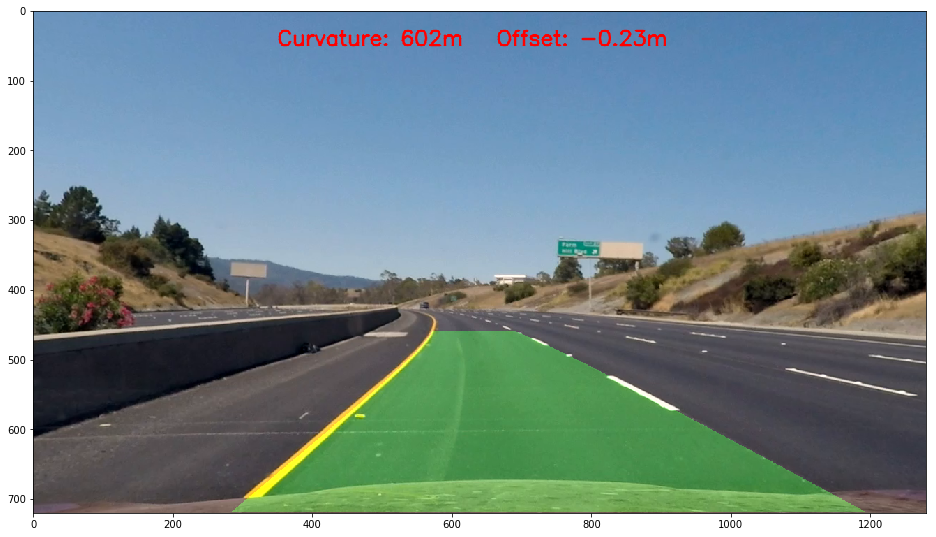

In [27]:

def proc_img(img, Lane, R, L):
    
    # undistort, threshold, and warp the image
    undist_img = undistort(img, UNDIST_MTRX, UNDIST_DIST)
    thresh_img = thresh_fcn(undist_img, plot=False)
    warp_img = warpPers(thresh_img, WARP_MTRX);
    
    # used for calculating offset
    img_cntr = img.shape[1]/2
    
    # Check to see if we've failed to find a fit in the last n attempts
    if(L.fail or R.fail): # if so, run the full pixel search
        print("Running full pixel search.")
        L.allx, L.ally, L.conf_this, R.allx, R.ally, R.conf_this, out_img = find_lane_pixels(warp_img)
        L_fit, L_success = fit_polynomial(L.allx, L.ally)
        R_fit, R_success = fit_polynomial(R.allx, R.ally)

    else: # Otherwise, try fitting around previous polynomials
        L_fit, L.allx, L.ally, L_success = search_around_poly(warp_img, L.fit_this) # last best fit
        R_fit, R.allx, R.ally, R_success = search_around_poly(warp_img, R.fit_this) # last fit
        
        
    # Check for fit success
    if((L_success == True) and (R_success == True)): 

        # calculate curvature
        L_curv = calc_curv(CURV_LOC, L_fit, MPX, MPY)
        R_curv = calc_curv(CURV_LOC, R_fit, MPX, MPY)
        
        # Check lane width
        lane_width = eval_poly(R_fit, R.poly_yval) - eval_poly(L_fit, L.poly_yval)
        
        if( (abs(lane_width - Lane.width) < 150) and  # lane width is okay
            (L.check_fit(L_fit)) and  # L fit is good
            (R.check_fit(R_fit))): # R fit is good
           
            L.push_fit(L_fit)
            L.report(True)
            R.push_fit(R_fit)
            R.report(True)
            
            L.curv = L_curv
            R.curv = R_curv
            Lane.push_curv((L.curv + R.curv)/2.0)
            
            offset = (((L.x_best+R.x_best)/2.0)-img_cntr)*MPX
            Lane.push_ofst(offset)
            
        else:
            print("Failed sanity check")
            L.report(False)
            R.report(False)

    else: 
        print("Fit unsuccessful")
        L.report(False)
        R.report(False)

    if((L.fit_best is None) or (R.fit_best is None)):
        # we don't have a fit at all; plot the image
        return img
    
    else:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        img_for_text = plot_lane(undist_img, warp_img, WARP_MTRX, L.eval_poly(ploty), R.eval_poly(ploty), ploty)

        #Plot text
        text_font = cv2.FONT_HERSHEY_SIMPLEX
        text_scale = 1
        text_location = (350,50)
        text_color = (255,0,0)
        text_line = cv2.LINE_AA
        text_thickness = 2
        text_string = "Curvature: {0:.0f}m   Offset: {1:.2f}m".format(float(Lane.curv), float(Lane.ofst))
        
        cv2.putText(img_for_text, text_string , text_location, text_font, text_scale, text_color, text_thickness, text_line)

        return img_for_text

    # increments interations
    L.incr()
    R.incr()


Lane1 = LaneInfo()
R_Line1 = Line()
L_Line1 = Line()

img = proc_img(raw_imgs[test_idx], Lane1, R_Line1, L_Line1)
plt.figure(figsize = (16, 10))
plt.imshow(img)


# Process the Video
Here, the pipeline is used to process the video, with the final result embedded below.

Note: failures of the fit or the sanity check are printed out here to given an estimate of the number of failures in the video. 

In [28]:
Lane2 = LaneInfo()
R_Line2 = Line()
L_Line2 = Line()
from IPython.display import HTML

output_file1 = 'output_images/output.mp4'
output_clip1 = clip1.fl_image(lambda image: proc_img(image, Lane2, R_Line2, L_Line2))#.subclip(19,30)
%time output_clip1.write_videofile(output_file1, audio=False)

Running full pixel search.
lane width:  791.851709352
[MoviePy] >>>> Building video output_images/output.mp4
[MoviePy] Writing video output_images/output.mp4



  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

lane width:  791.851709352
lane width:  792.079480586



  0%|▏                                                                                | 2/1261 [00:00<01:15, 16.71it/s]

lane width:  793.015034726
lane width:  790.316148245



  0%|▎                                                                                | 4/1261 [00:00<01:16, 16.37it/s]

lane width:  790.08791008
lane width:  787.71117952



  0%|▍                                                                                | 6/1261 [00:00<01:15, 16.53it/s]

lane width:  786.293801332
lane width:  800.258791134



  1%|▌                                                                                | 8/1261 [00:00<01:14, 16.75it/s]

lane width:  794.816799748
lane width:  794.96374496



  1%|▋                                                                               | 10/1261 [00:00<01:14, 16.82it/s]

lane width:  792.408772051
lane width:  797.184816976



  1%|▊                                                                               | 12/1261 [00:00<01:13, 17.02it/s]

lane width:  794.308257107
lane width:  788.510695331



  1%|▉                                                                               | 14/1261 [00:00<01:12, 17.12it/s]

lane width:  784.504370021
lane width:  775.212799385



  1%|█                                                                               | 16/1261 [00:00<01:12, 17.21it/s]

lane width:  774.856163102
lane width:  773.0372848



  1%|█▏                                                                              | 18/1261 [00:01<01:12, 17.22it/s]

lane width:  775.703598163
lane width:  776.623249753



  2%|█▎                                                                              | 20/1261 [00:01<01:12, 17.20it/s]

lane width:  777.810645588
lane width:  777.67810111



  2%|█▍                                                                              | 22/1261 [00:01<01:12, 17.15it/s]

lane width:  781.328049992
lane width:  782.679675864



  2%|█▌                                                                              | 24/1261 [00:01<01:12, 17.15it/s]

lane width:  785.488889258
lane width:  786.859207084



  2%|█▋                                                                              | 26/1261 [00:01<01:12, 17.14it/s]

lane width:  792.810166588
lane width:  796.803605122



  2%|█▊                                                                              | 28/1261 [00:01<01:11, 17.17it/s]

lane width:  795.683122819
lane width:  798.401508821



  2%|█▉                                                                              | 30/1261 [00:01<01:11, 17.17it/s]

lane width:  798.628455152
lane width:  797.028319128



  3%|██                                                                              | 32/1261 [00:01<01:11, 17.18it/s]

lane width:  804.544109788
lane width:  807.920751001



  3%|██▏                                                                             | 34/1261 [00:01<01:11, 17.05it/s]

lane width:  811.630208671
lane width:  802.350841796



  3%|██▎                                                                             | 36/1261 [00:02<01:11, 17.03it/s]

lane width:  795.983103021
lane width:  792.662604153



  3%|██▍                                                                             | 38/1261 [00:02<01:11, 16.99it/s]

lane width:  791.356917957
lane width:  788.717639496



  3%|██▌                                                                             | 40/1261 [00:02<01:11, 16.96it/s]

lane width:  783.65188283
lane width:  783.727317107



  3%|██▋                                                                             | 42/1261 [00:02<01:11, 16.94it/s]

lane width:  784.681173994
lane width:  785.691785905



  3%|██▊                                                                             | 44/1261 [00:02<01:11, 16.91it/s]

lane width:  787.016344012
lane width:  798.031865608



  4%|██▉                                                                             | 46/1261 [00:02<01:11, 16.90it/s]

lane width:  792.113563216
lane width:  789.710910895



  4%|███                                                                             | 48/1261 [00:02<01:11, 16.91it/s]

lane width:  790.801758615
lane width:  789.076069217



  4%|███▏                                                                            | 50/1261 [00:02<01:11, 16.90it/s]

lane width:  784.246103667
lane width:  779.641940411



  4%|███▎                                                                            | 52/1261 [00:03<01:11, 16.91it/s]

lane width:  774.165312717
lane width:  774.659875103



  4%|███▍                                                                            | 54/1261 [00:03<01:11, 16.87it/s]

lane width:  776.098550256
lane width:  777.018138545



  4%|███▌                                                                            | 56/1261 [00:03<01:11, 16.84it/s]

lane width:  778.147092702
lane width:  782.076870161



  5%|███▋                                                                            | 58/1261 [00:03<01:11, 16.83it/s]

lane width:  790.547343836
lane width:  784.842712053



  5%|███▊                                                                            | 60/1261 [00:03<01:11, 16.81it/s]

lane width:  785.351205534
lane width:  783.396643349



 12%|█████████▌                                                                     | 152/1261 [00:20<02:25,  7.60it/s]

lane width:  782.15651514
lane width:  781.850472503



  5%|████                                                                            | 64/1261 [00:03<01:11, 16.81it/s]

lane width:  782.107936982
lane width:  780.853764565



  5%|████▏                                                                           | 66/1261 [00:03<01:11, 16.75it/s]

lane width:  780.70428416
lane width:  783.10362469



  5%|████▎                                                                           | 68/1261 [00:04<01:11, 16.75it/s]

lane width:  781.426311554
lane width:  782.772535841



  6%|████▍                                                                           | 70/1261 [00:04<01:11, 16.74it/s]

lane width:  792.864812917
lane width:  789.33613981



  6%|████▌                                                                           | 72/1261 [00:04<01:11, 16.73it/s]

lane width:  786.749445118
lane width:  781.35849947



  6%|████▋                                                                           | 74/1261 [00:04<01:10, 16.72it/s]

lane width:  779.516522796
lane width:  773.41003319



  6%|████▊                                                                           | 76/1261 [00:04<01:10, 16.70it/s]

lane width:  771.402224786
lane width:  773.88322113



  6%|████▉                                                                           | 78/1261 [00:04<01:10, 16.69it/s]

lane width:  773.480397548
lane width:  776.354495427



  6%|█████                                                                           | 80/1261 [00:04<01:10, 16.69it/s]

lane width:  778.095663819
lane width:  781.712733199



  7%|█████▏                                                                          | 82/1261 [00:04<01:10, 16.69it/s]

lane width:  788.320671777
lane width:  805.354736199



  7%|█████▎                                                                          | 84/1261 [00:05<01:10, 16.69it/s]

lane width:  807.135294678
lane width:  812.145141927



  7%|█████▍                                                                          | 86/1261 [00:05<01:10, 16.69it/s]

lane width:  807.961760295
lane width:  799.318753728



  7%|█████▌                                                                          | 88/1261 [00:05<01:10, 16.68it/s]

lane width:  801.881617188
lane width:  791.559876496



  7%|█████▋                                                                          | 90/1261 [00:05<01:10, 16.68it/s]

lane width:  793.514576122
lane width:  790.678936418



  7%|█████▊                                                                          | 92/1261 [00:05<01:10, 16.67it/s]

lane width:  789.727181275
lane width:  787.130346225



  7%|█████▉                                                                          | 94/1261 [00:05<01:09, 16.67it/s]

lane width:  786.708055643
lane width:  788.504065361



  8%|██████                                                                          | 96/1261 [00:05<01:09, 16.65it/s]

lane width:  780.345657383
lane width:  784.979970451



  8%|██████▏                                                                         | 98/1261 [00:05<01:09, 16.66it/s]

lane width:  779.628230862
lane width:  779.773950359



  8%|██████▎                                                                        | 100/1261 [00:06<01:09, 16.66it/s]

lane width:  769.205016815
lane width:  768.861694023



  8%|██████▍                                                                        | 102/1261 [00:06<01:09, 16.66it/s]

lane width:  769.226957199
lane width:  769.448213887



  8%|██████▌                                                                        | 104/1261 [00:06<01:09, 16.67it/s]

lane width:  773.223578882
lane width:  777.286869427



  8%|██████▋                                                                        | 106/1261 [00:06<01:09, 16.69it/s]

lane width:  781.228364431
lane width:  782.03390253



  9%|██████▊                                                                        | 108/1261 [00:06<01:09, 16.69it/s]

lane width:  792.535019374
lane width:  793.699111816



  9%|██████▉                                                                        | 110/1261 [00:06<01:08, 16.68it/s]

lane width:  792.853101438
lane width:  795.300491155



  9%|███████                                                                        | 112/1261 [00:06<01:08, 16.68it/s]

lane width:  794.056493065
lane width:  790.61882081



  9%|███████▏                                                                       | 114/1261 [00:06<01:08, 16.68it/s]

lane width:  785.960858902
lane width:  778.049042363



  9%|███████▎                                                                       | 116/1261 [00:06<01:08, 16.69it/s]

lane width:  778.212985726
lane width:  778.705691359



  9%|███████▍                                                                       | 118/1261 [00:07<01:08, 16.69it/s]

lane width:  778.656278543
lane width:  777.157889343



 10%|███████▌                                                                       | 120/1261 [00:07<01:08, 16.71it/s]

lane width:  779.094814743
lane width:  785.092138802



 10%|███████▋                                                                       | 122/1261 [00:07<01:08, 16.70it/s]

lane width:  777.380367797
lane width:  778.623955567



 10%|███████▊                                                                       | 124/1261 [00:07<01:08, 16.71it/s]

lane width:  776.829493307
lane width:  777.649333083



 10%|███████▉                                                                       | 126/1261 [00:07<01:07, 16.72it/s]

lane width:  774.390743036
lane width:  775.178197968



 10%|████████                                                                       | 128/1261 [00:07<01:07, 16.73it/s]

lane width:  771.60929727
lane width:  771.569021562



 10%|████████▏                                                                      | 130/1261 [00:07<01:07, 16.73it/s]

lane width:  772.190751935
lane width:  770.322805305



 10%|████████▎                                                                      | 132/1261 [00:07<01:07, 16.72it/s]

lane width:  771.636738946
lane width:  776.635889233



 11%|████████▍                                                                      | 134/1261 [00:08<01:07, 16.71it/s]

lane width:  778.73166226
lane width:  779.647244598



 11%|████████▌                                                                      | 136/1261 [00:08<01:07, 16.71it/s]

lane width:  777.805825091
lane width:  780.264961595



 11%|████████▋                                                                      | 138/1261 [00:08<01:07, 16.70it/s]

lane width:  782.458577621
lane width:  783.519887504



 11%|████████▊                                                                      | 140/1261 [00:08<01:07, 16.68it/s]

lane width:  785.866962573
lane width:  784.11885564



 11%|████████▉                                                                      | 142/1261 [00:08<01:07, 16.69it/s]

lane width:  782.401517988
lane width:  781.223099325



 11%|█████████                                                                      | 144/1261 [00:08<01:06, 16.69it/s]

lane width:  782.568484212
lane width:  784.111816171



 12%|█████████▏                                                                     | 146/1261 [00:08<01:06, 16.69it/s]

lane width:  796.322214237
lane width:  787.150110914



 12%|█████████▎                                                                     | 148/1261 [00:08<01:06, 16.70it/s]

lane width:  788.574274305
lane width:  785.52849927



 12%|█████████▍                                                                     | 150/1261 [00:08<01:06, 16.70it/s]

lane width:  778.989426883
lane width:  781.521800908



 12%|█████████▌                                                                     | 152/1261 [00:09<01:06, 16.69it/s]

lane width:  773.125149328
lane width:  776.248130517



 12%|█████████▋                                                                     | 154/1261 [00:09<01:06, 16.70it/s]

lane width:  781.147189681
lane width:  780.950645145



 12%|█████████▊                                                                     | 156/1261 [00:09<01:06, 16.70it/s]

lane width:  782.277103451
lane width:  780.565936498



 13%|█████████▉                                                                     | 158/1261 [00:09<01:06, 16.69it/s]

lane width:  796.107314549
lane width:  792.742576138



 13%|██████████                                                                     | 160/1261 [00:09<01:05, 16.69it/s]

lane width:  798.388091949
lane width:  798.547158491



 13%|██████████▏                                                                    | 162/1261 [00:09<01:05, 16.69it/s]

lane width:  799.16081246
lane width:  802.360164831



 13%|██████████▎                                                                    | 164/1261 [00:09<01:05, 16.70it/s]

lane width:  795.035096452
lane width:  790.984778935



 13%|██████████▍                                                                    | 166/1261 [00:09<01:05, 16.69it/s]

lane width:  788.483526105
lane width:  789.832607502



 13%|██████████▌                                                                    | 168/1261 [00:10<01:05, 16.69it/s]

lane width:  790.188354808
lane width:  791.819601204



 13%|██████████▋                                                                    | 170/1261 [00:10<01:05, 16.70it/s]

lane width:  787.237952138
lane width:  784.020211699



 14%|██████████▊                                                                    | 172/1261 [00:10<01:05, 16.70it/s]

lane width:  781.829970356
lane width:  782.141745743



 14%|██████████▉                                                                    | 174/1261 [00:10<01:05, 16.71it/s]

lane width:  780.839203505
lane width:  775.94681305



 14%|███████████                                                                    | 176/1261 [00:10<01:04, 16.71it/s]

lane width:  778.521598949
lane width:  778.30323165



 14%|███████████▏                                                                   | 178/1261 [00:10<01:04, 16.71it/s]

lane width:  787.746187202
lane width:  791.424685692



 14%|███████████▎                                                                   | 180/1261 [00:10<01:04, 16.71it/s]

lane width:  795.029971444
lane width:  800.525958341



 14%|███████████▍                                                                   | 182/1261 [00:10<01:04, 16.71it/s]

lane width:  803.170772127
lane width:  814.160840639



 15%|███████████▌                                                                   | 184/1261 [00:11<01:04, 16.70it/s]

lane width:  811.917472131
lane width:  810.837183235



 15%|███████████▋                                                                   | 186/1261 [00:11<01:04, 16.70it/s]

lane width:  811.893697795
lane width:  807.230182186



 15%|███████████▊                                                                   | 188/1261 [00:11<01:04, 16.70it/s]

lane width:  802.355115477
lane width:  798.995606494



 15%|███████████▉                                                                   | 190/1261 [00:11<01:04, 16.70it/s]

lane width:  793.951381897
lane width:  791.768952006



 15%|████████████                                                                   | 192/1261 [00:11<01:04, 16.70it/s]

lane width:  786.874404019
lane width:  783.371767054



 15%|████████████▏                                                                  | 194/1261 [00:11<01:03, 16.69it/s]

lane width:  782.425273012
lane width:  791.229391834



 16%|████████████▎                                                                  | 196/1261 [00:11<01:03, 16.70it/s]

lane width:  799.427934661
lane width:  803.884653512



 16%|████████████▍                                                                  | 198/1261 [00:11<01:03, 16.70it/s]

lane width:  808.345825291
lane width:  805.607932025



 16%|████████████▌                                                                  | 200/1261 [00:11<01:03, 16.69it/s]

lane width:  804.880142718
lane width:  801.654051206



 16%|████████████▋                                                                  | 202/1261 [00:12<01:03, 16.69it/s]

lane width:  802.544351128
lane width:  803.664171819



 16%|████████████▊                                                                  | 204/1261 [00:12<01:03, 16.69it/s]

lane width:  799.736615682
lane width:  799.19080987



 16%|████████████▉                                                                  | 206/1261 [00:12<01:03, 16.69it/s]

lane width:  795.599599276
lane width:  801.148295604



 16%|█████████████                                                                  | 208/1261 [00:12<01:03, 16.69it/s]

lane width:  802.916772713
lane width:  802.867074668



 17%|█████████████▏                                                                 | 210/1261 [00:12<01:03, 16.68it/s]

lane width:  804.357015771
lane width:  803.763245461



 17%|█████████████▎                                                                 | 212/1261 [00:12<01:02, 16.67it/s]

lane width:  800.483287801
lane width:  800.112271927



 17%|█████████████▍                                                                 | 214/1261 [00:12<01:02, 16.67it/s]

lane width:  797.463189415
lane width:  796.836700045



 17%|█████████████▌                                                                 | 216/1261 [00:12<01:02, 16.68it/s]

lane width:  796.362817307
lane width:  796.330066264



 17%|█████████████▋                                                                 | 218/1261 [00:13<01:02, 16.68it/s]

lane width:  792.260884863
lane width:  794.299438259



 17%|█████████████▊                                                                 | 220/1261 [00:13<01:02, 16.67it/s]

lane width:  806.249386253
lane width:  799.659111281



 18%|█████████████▉                                                                 | 222/1261 [00:13<01:02, 16.68it/s]

lane width:  799.953668416
lane width:  794.160234653



 18%|██████████████                                                                 | 224/1261 [00:13<01:02, 16.68it/s]

lane width:  796.139228734
lane width:  791.693052513



 18%|██████████████▏                                                                | 226/1261 [00:13<01:02, 16.68it/s]

lane width:  787.909533443
lane width:  781.259064334



 18%|██████████████▎                                                                | 228/1261 [00:13<01:01, 16.68it/s]

lane width:  780.497171126
lane width:  781.574175767



 18%|██████████████▍                                                                | 230/1261 [00:13<01:01, 16.69it/s]

lane width:  779.414715496
lane width:  780.660485799



 18%|██████████████▌                                                                | 232/1261 [00:13<01:01, 16.68it/s]

lane width:  783.013814535
lane width:  781.704532368



 19%|██████████████▋                                                                | 234/1261 [00:14<01:01, 16.68it/s]

lane width:  784.534545336
lane width:  785.661426923



 19%|██████████████▊                                                                | 236/1261 [00:14<01:01, 16.68it/s]

lane width:  776.321160695
lane width:  782.83092221



 19%|██████████████▉                                                                | 238/1261 [00:14<01:01, 16.68it/s]

lane width:  777.009487361
lane width:  780.50424441



 19%|███████████████                                                                | 240/1261 [00:14<01:01, 16.68it/s]

lane width:  782.64101862
lane width:  788.532713164



 19%|███████████████▏                                                               | 242/1261 [00:14<01:01, 16.68it/s]

lane width:  788.347719848
lane width:  789.818748922



 19%|███████████████▎                                                               | 244/1261 [00:14<01:00, 16.68it/s]

lane width:  801.044546085
lane width:  797.990929398



 20%|███████████████▍                                                               | 246/1261 [00:14<01:00, 16.67it/s]

lane width:  798.860273114
lane width:  792.123256608



 20%|███████████████▌                                                               | 248/1261 [00:14<01:00, 16.67it/s]

lane width:  795.496626004
lane width:  794.730073926



 20%|███████████████▋                                                               | 250/1261 [00:14<01:00, 16.68it/s]

lane width:  788.974636678
lane width:  790.179200239



 20%|███████████████▊                                                               | 252/1261 [00:15<01:00, 16.67it/s]

lane width:  789.65130514
lane width:  790.924403987



 20%|███████████████▉                                                               | 254/1261 [00:15<01:00, 16.68it/s]

lane width:  789.945254453
lane width:  790.698896746



 20%|████████████████                                                               | 256/1261 [00:15<01:00, 16.68it/s]

lane width:  801.179996555
lane width:  796.808924914



 20%|████████████████▏                                                              | 258/1261 [00:15<01:00, 16.67it/s]

lane width:  797.274296766
lane width:  795.254830022



 21%|████████████████▎                                                              | 260/1261 [00:15<01:00, 16.67it/s]

lane width:  795.05073228
lane width:  788.422115394



 21%|████████████████▍                                                              | 262/1261 [00:15<00:59, 16.67it/s]

lane width:  782.721316925
lane width:  786.122223561



 21%|████████████████▌                                                              | 264/1261 [00:15<00:59, 16.67it/s]

lane width:  788.943177569
lane width:  795.089035314



 21%|████████████████▋                                                              | 266/1261 [00:15<00:59, 16.66it/s]

lane width:  795.568470904
lane width:  797.170931958



 21%|████████████████▊                                                              | 268/1261 [00:16<00:59, 16.67it/s]

lane width:  800.595461459
lane width:  810.777307834



 21%|████████████████▉                                                              | 270/1261 [00:16<00:59, 16.67it/s]

lane width:  811.024191872
lane width:  805.41816865



 22%|█████████████████                                                              | 272/1261 [00:16<00:59, 16.67it/s]

lane width:  801.875143431
lane width:  794.452487714



 22%|█████████████████▏                                                             | 274/1261 [00:16<00:59, 16.66it/s]

lane width:  796.665504596
lane width:  798.072636805



 22%|█████████████████▎                                                             | 276/1261 [00:16<00:59, 16.67it/s]

lane width:  797.661698605
lane width:  798.459429862



 22%|█████████████████▍                                                             | 278/1261 [00:16<00:58, 16.66it/s]

lane width:  795.014103549
lane width:  792.864374203



 22%|█████████████████▌                                                             | 280/1261 [00:16<00:58, 16.66it/s]

lane width:  800.455522799
lane width:  797.030547493



 22%|█████████████████▋                                                             | 282/1261 [00:16<00:58, 16.66it/s]

lane width:  797.947477463
lane width:  797.952597358



 23%|█████████████████▊                                                             | 284/1261 [00:17<00:58, 16.66it/s]

lane width:  795.771215715
lane width:  799.824904387



 23%|█████████████████▉                                                             | 286/1261 [00:17<00:58, 16.65it/s]

lane width:  799.977854518
lane width:  801.129594542



 23%|██████████████████                                                             | 288/1261 [00:17<00:58, 16.66it/s]

lane width:  793.756549592
lane width:  795.181197854



 23%|██████████████████▏                                                            | 290/1261 [00:17<00:58, 16.66it/s]

lane width:  792.81464548
lane width:  790.622716427



 23%|██████████████████▎                                                            | 292/1261 [00:17<00:58, 16.66it/s]

lane width:  798.932522062
lane width:  794.86502234



 23%|██████████████████▍                                                            | 294/1261 [00:17<00:58, 16.66it/s]

lane width:  795.51137133
lane width:  795.849032043



 23%|██████████████████▌                                                            | 296/1261 [00:17<00:57, 16.65it/s]

lane width:  792.879782389
lane width:  791.175064452



 24%|██████████████████▋                                                            | 298/1261 [00:17<00:57, 16.66it/s]

lane width:  788.357197584
lane width:  791.381798553



 24%|██████████████████▊                                                            | 300/1261 [00:18<00:57, 16.66it/s]

lane width:  791.842212904
lane width:  795.35495182



 24%|██████████████████▉                                                            | 302/1261 [00:18<00:57, 16.64it/s]

lane width:  796.636497372
lane width:  796.049759127



 24%|███████████████████                                                            | 304/1261 [00:18<00:57, 16.64it/s]

lane width:  809.826491141
lane width:  806.919348121



 24%|███████████████████▏                                                           | 306/1261 [00:18<00:57, 16.64it/s]

lane width:  810.565795725
lane width:  804.902495742



 24%|███████████████████▎                                                           | 308/1261 [00:18<00:57, 16.63it/s]

lane width:  803.379658017
lane width:  800.761247882



 25%|███████████████████▍                                                           | 310/1261 [00:18<00:57, 16.63it/s]

lane width:  795.007448995
lane width:  790.76106044



 25%|███████████████████▌                                                           | 312/1261 [00:18<00:57, 16.63it/s]

lane width:  785.06587603
lane width:  783.909864703



 25%|███████████████████▋                                                           | 314/1261 [00:18<00:56, 16.63it/s]

lane width:  783.181533476
lane width:  783.134319355



 25%|███████████████████▊                                                           | 316/1261 [00:18<00:56, 16.63it/s]

lane width:  789.27554885
lane width:  786.01942066



 25%|███████████████████▉                                                           | 318/1261 [00:19<00:56, 16.64it/s]

lane width:  783.726762156
lane width:  781.711986267



 25%|████████████████████                                                           | 320/1261 [00:19<00:56, 16.63it/s]

lane width:  777.830218811
lane width:  766.765245188



 26%|████████████████████▏                                                          | 322/1261 [00:19<00:56, 16.63it/s]

lane width:  766.615497351
lane width:  772.376601842



 26%|████████████████████▎                                                          | 324/1261 [00:19<00:56, 16.64it/s]

lane width:  772.701878543
lane width:  774.425618957



 26%|████████████████████▍                                                          | 326/1261 [00:19<00:56, 16.63it/s]

lane width:  778.288343998
lane width:  780.114338388



 26%|████████████████████▌                                                          | 328/1261 [00:19<00:56, 16.64it/s]

lane width:  793.711440922
lane width:  796.641090274



 26%|████████████████████▋                                                          | 330/1261 [00:19<00:55, 16.63it/s]

lane width:  796.285266081
lane width:  789.557816917



 26%|████████████████████▊                                                          | 332/1261 [00:19<00:55, 16.63it/s]

lane width:  785.441660303
lane width:  784.947084238



 26%|████████████████████▉                                                          | 334/1261 [00:20<00:55, 16.63it/s]

lane width:  784.669113626
lane width:  788.440114692



 27%|█████████████████████                                                          | 336/1261 [00:20<00:55, 16.63it/s]

lane width:  789.02471772
lane width:  789.040318205



 27%|█████████████████████▏                                                         | 338/1261 [00:20<00:55, 16.63it/s]

lane width:  788.914285395
lane width:  786.078132222



 27%|█████████████████████▎                                                         | 340/1261 [00:20<00:55, 16.63it/s]

lane width:  791.192227044
lane width:  793.646590577



 27%|█████████████████████▍                                                         | 342/1261 [00:20<00:55, 16.63it/s]

lane width:  791.317374319
lane width:  791.280028177



 27%|█████████████████████▌                                                         | 344/1261 [00:20<00:55, 16.63it/s]

lane width:  791.033210172
lane width:  787.729038883



 27%|█████████████████████▋                                                         | 346/1261 [00:20<00:55, 16.62it/s]

lane width:  778.535257768
lane width:  780.726354693



 28%|█████████████████████▊                                                         | 348/1261 [00:20<00:54, 16.62it/s]

lane width:  782.406846536
lane width:  785.054678608



 28%|█████████████████████▉                                                         | 350/1261 [00:21<00:54, 16.62it/s]

lane width:  786.256240626
lane width:  788.197611856



 28%|██████████████████████                                                         | 352/1261 [00:21<00:54, 16.62it/s]

lane width:  793.932939972
lane width:  800.715969346



 28%|██████████████████████▏                                                        | 354/1261 [00:21<00:54, 16.62it/s]

lane width:  806.432200384
lane width:  801.244858523



 28%|██████████████████████▎                                                        | 356/1261 [00:21<00:54, 16.62it/s]

lane width:  792.908476202
lane width:  788.141901455



 28%|██████████████████████▍                                                        | 358/1261 [00:21<00:54, 16.62it/s]

lane width:  781.86370434
lane width:  782.852632129



 29%|██████████████████████▌                                                        | 360/1261 [00:21<00:54, 16.62it/s]

lane width:  779.992881272
lane width:  775.921406679



 29%|██████████████████████▋                                                        | 362/1261 [00:21<00:54, 16.62it/s]

lane width:  773.788689171
lane width:  770.059112095



 29%|██████████████████████▊                                                        | 364/1261 [00:21<00:53, 16.62it/s]

lane width:  778.172957415
lane width:  779.999061162



 29%|██████████████████████▉                                                        | 366/1261 [00:22<00:53, 16.62it/s]

lane width:  777.00953955
lane width:  775.57544369



 29%|███████████████████████                                                        | 368/1261 [00:22<00:53, 16.62it/s]

lane width:  773.122956704
lane width:  775.100595005



 29%|███████████████████████▏                                                       | 370/1261 [00:22<00:53, 16.62it/s]

lane width:  775.345089174
lane width:  779.272360412



 30%|███████████████████████▎                                                       | 372/1261 [00:22<00:53, 16.62it/s]

lane width:  782.699316601
lane width:  784.427445469



 30%|███████████████████████▍                                                       | 374/1261 [00:22<00:53, 16.62it/s]

lane width:  787.284790152
lane width:  787.693050692



 30%|███████████████████████▌                                                       | 376/1261 [00:22<00:53, 16.62it/s]

lane width:  805.595804899
lane width:  800.932656477



 30%|███████████████████████▋                                                       | 378/1261 [00:22<00:53, 16.62it/s]

lane width:  803.178135572
lane width:  805.832796407



 30%|███████████████████████▊                                                       | 380/1261 [00:22<00:53, 16.62it/s]

lane width:  800.677978538
lane width:  802.789311926



 30%|███████████████████████▉                                                       | 382/1261 [00:22<00:52, 16.62it/s]

lane width:  792.190742874
lane width:  792.813491928



 30%|████████████████████████                                                       | 384/1261 [00:23<00:52, 16.61it/s]

lane width:  790.846348609
lane width:  791.215811621



 31%|████████████████████████▏                                                      | 386/1261 [00:23<00:52, 16.61it/s]

lane width:  792.273786797
lane width:  790.000158527



 31%|████████████████████████▎                                                      | 388/1261 [00:23<00:52, 16.61it/s]

lane width:  791.655165278
lane width:  798.176810973



 31%|████████████████████████▍                                                      | 390/1261 [00:23<00:52, 16.61it/s]

lane width:  798.177221256
lane width:  795.428678057



 31%|████████████████████████▌                                                      | 392/1261 [00:23<00:52, 16.60it/s]

lane width:  792.283024435
lane width:  787.208943106



 31%|████████████████████████▋                                                      | 394/1261 [00:23<00:52, 16.60it/s]

lane width:  786.430686072
lane width:  785.105299028



 31%|████████████████████████▊                                                      | 396/1261 [00:23<00:52, 16.60it/s]

lane width:  785.765076364
lane width:  788.270421242



 32%|████████████████████████▉                                                      | 398/1261 [00:23<00:52, 16.60it/s]

lane width:  790.364502213
lane width:  790.440820143



 32%|█████████████████████████                                                      | 400/1261 [00:24<00:51, 16.59it/s]

lane width:  793.377583031
lane width:  803.790975974



 32%|█████████████████████████▏                                                     | 402/1261 [00:24<00:51, 16.60it/s]

lane width:  795.928887032
lane width:  792.682331262



 32%|█████████████████████████▎                                                     | 404/1261 [00:24<00:51, 16.59it/s]

lane width:  789.981570863
lane width:  788.366256962



 32%|█████████████████████████▍                                                     | 406/1261 [00:24<00:51, 16.60it/s]

lane width:  788.320320216
lane width:  783.838958109



 32%|█████████████████████████▌                                                     | 408/1261 [00:24<00:51, 16.60it/s]

lane width:  784.48352181
lane width:  781.58837448



 33%|█████████████████████████▋                                                     | 410/1261 [00:24<00:51, 16.59it/s]

lane width:  782.877550336
lane width:  784.27859266



 33%|█████████████████████████▊                                                     | 412/1261 [00:24<00:51, 16.59it/s]

lane width:  786.742531682
lane width:  797.291271938



 33%|█████████████████████████▉                                                     | 414/1261 [00:24<00:51, 16.59it/s]

lane width:  795.748285071
lane width:  798.304992735



 33%|██████████████████████████                                                     | 416/1261 [00:25<00:50, 16.59it/s]

lane width:  795.588027484
lane width:  795.826022015



 33%|██████████████████████████▏                                                    | 418/1261 [00:25<00:50, 16.58it/s]

lane width:  796.90479078
lane width:  790.442018207



 33%|██████████████████████████▎                                                    | 420/1261 [00:25<00:50, 16.58it/s]

lane width:  791.175778042
lane width:  786.267255316



 33%|██████████████████████████▍                                                    | 422/1261 [00:25<00:50, 16.58it/s]

lane width:  787.667818823
lane width:  787.599793916



 34%|██████████████████████████▌                                                    | 424/1261 [00:25<00:50, 16.58it/s]

lane width:  789.034631287
lane width:  793.915045749



 34%|██████████████████████████▋                                                    | 426/1261 [00:25<00:50, 16.57it/s]

lane width:  793.36441659
lane width:  791.564481414



 34%|██████████████████████████▊                                                    | 428/1261 [00:25<00:50, 16.57it/s]

lane width:  786.758821431
lane width:  783.547682364



 34%|██████████████████████████▉                                                    | 430/1261 [00:25<00:50, 16.57it/s]

lane width:  786.638228514
lane width:  783.602008799



 34%|███████████████████████████                                                    | 432/1261 [00:26<00:50, 16.57it/s]

lane width:  786.775568006
lane width:  785.877226339



 34%|███████████████████████████▏                                                   | 434/1261 [00:26<00:49, 16.57it/s]

lane width:  786.238078918
lane width:  786.008938232



 35%|███████████████████████████▎                                                   | 436/1261 [00:26<00:49, 16.57it/s]

lane width:  788.136171439
lane width:  792.103493117



 35%|███████████████████████████▍                                                   | 438/1261 [00:26<00:49, 16.57it/s]

lane width:  789.526174885
lane width:  784.519734859



 35%|███████████████████████████▌                                                   | 440/1261 [00:26<00:49, 16.56it/s]

lane width:  786.292383023
lane width:  782.472725018



 35%|███████████████████████████▋                                                   | 442/1261 [00:26<00:49, 16.56it/s]

lane width:  788.361132615
lane width:  789.189265028



 35%|███████████████████████████▊                                                   | 444/1261 [00:26<00:49, 16.56it/s]

lane width:  790.751554853
lane width:  791.595966003



 35%|███████████████████████████▉                                                   | 446/1261 [00:26<00:49, 16.56it/s]

lane width:  790.363499252
lane width:  793.406254138



 36%|████████████████████████████                                                   | 448/1261 [00:27<00:49, 16.56it/s]

lane width:  806.060358212
lane width:  806.245049089



 36%|████████████████████████████▏                                                  | 450/1261 [00:27<00:48, 16.56it/s]

lane width:  803.519406472
lane width:  804.550490362



 36%|████████████████████████████▎                                                  | 452/1261 [00:27<00:48, 16.56it/s]

lane width:  806.190497258
lane width:  801.366156499



 36%|████████████████████████████▍                                                  | 454/1261 [00:27<00:48, 16.56it/s]

lane width:  800.316490875
lane width:  797.220699882



 36%|████████████████████████████▌                                                  | 456/1261 [00:27<00:48, 16.56it/s]

lane width:  795.973664487
lane width:  796.836614367



 36%|████████████████████████████▋                                                  | 458/1261 [00:27<00:48, 16.56it/s]

lane width:  794.427553091
lane width:  795.399658839



 36%|████████████████████████████▊                                                  | 460/1261 [00:27<00:48, 16.56it/s]

lane width:  805.845101963
lane width:  807.299051829



 37%|████████████████████████████▉                                                  | 462/1261 [00:27<00:48, 16.56it/s]

lane width:  810.130206011
lane width:  804.910104749



 37%|█████████████████████████████                                                  | 464/1261 [00:28<00:48, 16.56it/s]

lane width:  801.279004571
lane width:  799.011538499



 37%|█████████████████████████████▏                                                 | 466/1261 [00:28<00:47, 16.56it/s]

lane width:  799.072206778
lane width:  796.943018525



 37%|█████████████████████████████▎                                                 | 468/1261 [00:28<00:47, 16.56it/s]

lane width:  792.819653704
lane width:  793.982376145



 37%|█████████████████████████████▍                                                 | 470/1261 [00:28<00:47, 16.56it/s]

lane width:  790.071347101
lane width:  789.103754052



 37%|█████████████████████████████▌                                                 | 472/1261 [00:28<00:47, 16.56it/s]

lane width:  788.661269696
lane width:  784.47451019



 38%|█████████████████████████████▋                                                 | 474/1261 [00:28<00:47, 16.56it/s]

lane width:  784.291624845
lane width:  781.894541675



 38%|█████████████████████████████▊                                                 | 476/1261 [00:28<00:47, 16.55it/s]

lane width:  782.640388566
lane width:  779.361963629



 38%|█████████████████████████████▉                                                 | 478/1261 [00:28<00:47, 16.55it/s]

lane width:  780.004934631
lane width:  783.15964029



 38%|██████████████████████████████                                                 | 480/1261 [00:28<00:47, 16.56it/s]

lane width:  782.248896263
lane width:  785.69562841



 38%|██████████████████████████████▏                                                | 482/1261 [00:29<00:47, 16.56it/s]

lane width:  788.504004337
lane width:  789.689039828



 38%|██████████████████████████████▎                                                | 484/1261 [00:29<00:46, 16.56it/s]

lane width:  794.047352925
lane width:  797.317882419



 39%|██████████████████████████████▍                                                | 486/1261 [00:29<00:46, 16.56it/s]

lane width:  798.638498381
lane width:  796.491982386



 39%|██████████████████████████████▌                                                | 488/1261 [00:29<00:46, 16.56it/s]

lane width:  795.846014751
lane width:  794.960882119



 39%|██████████████████████████████▋                                                | 490/1261 [00:29<00:46, 16.56it/s]

lane width:  792.322111665
lane width:  792.649483138



 39%|██████████████████████████████▊                                                | 492/1261 [00:29<00:46, 16.56it/s]

lane width:  791.202416166
lane width:  793.070312848



 39%|██████████████████████████████▉                                                | 494/1261 [00:29<00:46, 16.56it/s]

lane width:  794.730875691
lane width:  793.44874289



 39%|███████████████████████████████                                                | 496/1261 [00:29<00:46, 16.56it/s]

lane width:  797.897978672
lane width:  795.175407752



 39%|███████████████████████████████▏                                               | 498/1261 [00:30<00:46, 16.56it/s]

lane width:  801.699919249
lane width:  803.65089313



 40%|███████████████████████████████▎                                               | 500/1261 [00:30<00:45, 16.56it/s]

lane width:  807.354739445
lane width:  812.870949771



 40%|███████████████████████████████▍                                               | 502/1261 [00:30<00:45, 16.56it/s]

lane width:  808.197833131
lane width:  807.91603946



 40%|███████████████████████████████▌                                               | 504/1261 [00:30<00:45, 16.56it/s]

lane width:  806.462834345
lane width:  807.063651217



 40%|███████████████████████████████▋                                               | 506/1261 [00:30<00:45, 16.56it/s]

lane width:  809.351211439
lane width:  808.69619875



 40%|███████████████████████████████▊                                               | 508/1261 [00:30<00:45, 16.56it/s]

lane width:  825.377903342
lane width:  815.071608038



 40%|███████████████████████████████▉                                               | 510/1261 [00:30<00:45, 16.56it/s]

lane width:  813.167859225
lane width:  810.288427981



 41%|████████████████████████████████                                               | 512/1261 [00:30<00:45, 16.56it/s]

lane width:  795.299528176
lane width:  799.031182121



 41%|████████████████████████████████▏                                              | 514/1261 [00:31<00:45, 16.56it/s]

lane width:  792.845192382
lane width:  795.593428302



 41%|████████████████████████████████▎                                              | 516/1261 [00:31<00:44, 16.56it/s]

lane width:  795.081711233
lane width:  794.033261153



 41%|████████████████████████████████▍                                              | 518/1261 [00:31<00:44, 16.56it/s]

lane width:  796.253291649
lane width:  794.857865824



 41%|████████████████████████████████▌                                              | 520/1261 [00:31<00:44, 16.56it/s]

lane width:  805.474013854
lane width:  808.04135894



 41%|████████████████████████████████▋                                              | 522/1261 [00:31<00:44, 16.56it/s]

lane width:  803.581566564
lane width:  805.595106532



 42%|████████████████████████████████▊                                              | 524/1261 [00:31<00:44, 16.56it/s]

lane width:  800.805078083
lane width:  803.025566484



 42%|████████████████████████████████▉                                              | 526/1261 [00:31<00:44, 16.56it/s]

lane width:  805.430867629
lane width:  804.576297229



 42%|█████████████████████████████████                                              | 528/1261 [00:31<00:44, 16.56it/s]

lane width:  800.713876635
lane width:  796.030973055



 42%|█████████████████████████████████▏                                             | 530/1261 [00:31<00:44, 16.56it/s]

lane width:  793.259953397
lane width:  788.028616112



 42%|█████████████████████████████████▎                                             | 532/1261 [00:32<00:44, 16.56it/s]

lane width:  806.896744194
lane width:  798.543487579



 42%|█████████████████████████████████▍                                             | 534/1261 [00:32<00:43, 16.56it/s]

lane width:  800.629212627
lane width:  803.034305865



 43%|█████████████████████████████████▌                                             | 536/1261 [00:32<00:43, 16.56it/s]

lane width:  797.248566347
lane width:  798.759287115



 43%|█████████████████████████████████▋                                             | 538/1261 [00:32<00:43, 16.56it/s]

lane width:  799.017400648
lane width:  798.719610265



 43%|█████████████████████████████████▊                                             | 540/1261 [00:32<00:43, 16.56it/s]

lane width:  798.248136991
lane width:  795.381000556



 43%|█████████████████████████████████▉                                             | 542/1261 [00:32<00:43, 16.56it/s]

lane width:  795.135624442
lane width:  787.111463156



 43%|██████████████████████████████████                                             | 544/1261 [00:32<00:43, 16.56it/s]

lane width:  791.106044211
lane width:  785.005535641



 43%|██████████████████████████████████▏                                            | 546/1261 [00:32<00:43, 16.56it/s]

lane width:  779.758651521
lane width:  773.800647546



 43%|██████████████████████████████████▎                                            | 548/1261 [00:33<00:43, 16.55it/s]

lane width:  777.57081937
lane width:  791.855145401



 44%|██████████████████████████████████▍                                            | 550/1261 [00:33<00:42, 16.55it/s]

lane width:  792.756029103
lane width:  792.517612686



 44%|██████████████████████████████████▌                                            | 552/1261 [00:33<00:42, 16.54it/s]

lane width:  795.244729493
lane width:  797.280294592



 44%|██████████████████████████████████▋                                            | 554/1261 [00:33<00:42, 16.54it/s]

lane width:  801.255629777
lane width:  801.83792722



 44%|██████████████████████████████████▊                                            | 556/1261 [00:33<00:42, 16.54it/s]

lane width:  800.191671603
lane width:  805.986731863



 44%|██████████████████████████████████▉                                            | 558/1261 [00:33<00:42, 16.53it/s]

lane width:  821.381859051
lane width:  839.752749621



 44%|███████████████████████████████████                                            | 560/1261 [00:33<00:42, 16.53it/s]

lane width:  846.786220191
lane width:  856.474486212



 45%|███████████████████████████████████▏                                           | 562/1261 [00:34<00:42, 16.53it/s]

lane width:  843.209685237
lane width:  830.775930195



 45%|███████████████████████████████████▎                                           | 564/1261 [00:34<00:42, 16.53it/s]

lane width:  825.774823711
lane width:  817.214700782



 45%|███████████████████████████████████▍                                           | 566/1261 [00:34<00:42, 16.52it/s]

lane width:  811.20449527
lane width:  804.347698649



 45%|███████████████████████████████████▌                                           | 568/1261 [00:34<00:41, 16.52it/s]

lane width:  808.281868869
lane width:  805.875825436



 45%|███████████████████████████████████▋                                           | 570/1261 [00:34<00:41, 16.52it/s]

lane width:  810.322269701
lane width:  810.42115591



 45%|███████████████████████████████████▊                                           | 572/1261 [00:34<00:41, 16.52it/s]

lane width:  812.696318964
lane width:  812.868018708



 46%|███████████████████████████████████▉                                           | 574/1261 [00:34<00:41, 16.52it/s]

lane width:  813.924228353
lane width:  814.102496088



 46%|████████████████████████████████████                                           | 576/1261 [00:34<00:41, 16.52it/s]

lane width:  831.543684465
lane width:  822.256303013



 46%|████████████████████████████████████▏                                          | 578/1261 [00:34<00:41, 16.52it/s]

lane width:  820.603545582
lane width:  823.67196776



 46%|████████████████████████████████████▎                                          | 580/1261 [00:35<00:41, 16.52it/s]

lane width:  822.988253133
lane width:  823.953130562



 46%|████████████████████████████████████▍                                          | 582/1261 [00:35<00:41, 16.52it/s]

lane width:  820.020656077
lane width:  820.803748468



 46%|████████████████████████████████████▌                                          | 584/1261 [00:35<00:40, 16.53it/s]

lane width:  819.717851248
lane width:  814.334980159



 46%|████████████████████████████████████▋                                          | 586/1261 [00:35<00:40, 16.53it/s]

lane width:  816.068915165
lane width:  813.358129558



 47%|████████████████████████████████████▊                                          | 588/1261 [00:35<00:40, 16.53it/s]

lane width:  825.297064996
lane width:  822.376083637



 47%|████████████████████████████████████▉                                          | 590/1261 [00:35<00:40, 16.53it/s]

lane width:  826.312381359
lane width:  824.25979192



 47%|█████████████████████████████████████                                          | 592/1261 [00:35<00:40, 16.53it/s]

lane width:  814.912972776
lane width:  819.795750858



 47%|█████████████████████████████████████▏                                         | 594/1261 [00:35<00:40, 16.54it/s]

lane width:  816.53455053
lane width:  817.431236929



 47%|█████████████████████████████████████▎                                         | 596/1261 [00:36<00:40, 16.54it/s]

lane width:  817.731428647
lane width:  818.706247694



 47%|█████████████████████████████████████▍                                         | 598/1261 [00:36<00:40, 16.54it/s]

lane width:  819.262175056
lane width:  817.91494778



 48%|█████████████████████████████████████▌                                         | 600/1261 [00:36<00:39, 16.54it/s]

lane width:  830.380728283
lane width:  831.660530836



 48%|█████████████████████████████████████▋                                         | 602/1261 [00:36<00:39, 16.54it/s]

lane width:  835.966608534
lane width:  834.409923196



 48%|█████████████████████████████████████▊                                         | 604/1261 [00:36<00:39, 16.53it/s]

lane width:  833.511849802
lane width:  839.024845586



 48%|█████████████████████████████████████▉                                         | 606/1261 [00:36<00:39, 16.53it/s]

lane width:  830.648047057
lane width:  831.863397307



 48%|██████████████████████████████████████                                         | 608/1261 [00:36<00:39, 16.53it/s]

lane width:  833.737660362
Fit diff exceeded
Failed sanity check
lane width:  833.797588237
Fit diff exceeded
Failed sanity check



 48%|██████████████████████████████████████▏                                        | 610/1261 [00:36<00:39, 16.53it/s]

lane width:  833.093279044
Fit diff exceeded
Failed sanity check
lane width:  827.352754689
Fit diff exceeded
Failed sanity check



 49%|██████████████████████████████████████▎                                        | 612/1261 [00:37<00:39, 16.53it/s]

lane width:  841.847017226
lane width:  824.872145121



 49%|██████████████████████████████████████▍                                        | 614/1261 [00:37<00:39, 16.53it/s]

lane width:  819.381023514
lane width:  819.362700346



 49%|██████████████████████████████████████▌                                        | 616/1261 [00:37<00:39, 16.53it/s]

lane width:  807.06100557
lane width:  798.586302247
Fit diff exceeded
Failed sanity check



 49%|██████████████████████████████████████▋                                        | 618/1261 [00:37<00:38, 16.53it/s]

lane width:  800.8104319
Fit diff exceeded
Failed sanity check
lane width:  798.709512441
Fit diff exceeded
Failed sanity check



 49%|██████████████████████████████████████▊                                        | 620/1261 [00:37<00:38, 16.53it/s]

lane width:  806.791148829
Fit diff exceeded
Failed sanity check
lane width:  807.160556411
Fit diff exceeded
Failed sanity check



 49%|██████████████████████████████████████▉                                        | 622/1261 [00:37<00:38, 16.53it/s]

lane width:  810.700485484
lane width:  810.178976122



 49%|███████████████████████████████████████                                        | 624/1261 [00:37<00:38, 16.54it/s]

lane width:  797.511488738
lane width:  789.347891084



 50%|███████████████████████████████████████▏                                       | 626/1261 [00:37<00:38, 16.53it/s]

lane width:  783.278864462
Fit diff exceeded
Failed sanity check
lane width:  776.094976905
Fit diff exceeded
Failed sanity check



 50%|███████████████████████████████████████▎                                       | 628/1261 [00:37<00:38, 16.53it/s]

lane width:  796.587593815
Fit diff exceeded
Failed sanity check
lane width:  814.448166991
Fit diff exceeded
Failed sanity check



 50%|███████████████████████████████████████▍                                       | 630/1261 [00:38<00:38, 16.53it/s]

lane width:  821.974336987
lane width:  830.805312075



 50%|███████████████████████████████████████▌                                       | 632/1261 [00:38<00:38, 16.52it/s]

lane width:  829.930745842
lane width:  825.362306642



 50%|███████████████████████████████████████▋                                       | 634/1261 [00:38<00:37, 16.52it/s]

lane width:  816.185551516
lane width:  807.807726341



 50%|███████████████████████████████████████▊                                       | 636/1261 [00:38<00:37, 16.53it/s]

lane width:  796.955399053
lane width:  792.269078217



 51%|███████████████████████████████████████▉                                       | 638/1261 [00:38<00:37, 16.52it/s]

lane width:  795.160729965
lane width:  801.267825234



 51%|████████████████████████████████████████                                       | 640/1261 [00:38<00:37, 16.52it/s]

lane width:  809.116859834
lane width:  813.892930983



 51%|████████████████████████████████████████▏                                      | 642/1261 [00:38<00:37, 16.52it/s]

lane width:  813.730895189
lane width:  805.342285408



 51%|████████████████████████████████████████▎                                      | 644/1261 [00:38<00:37, 16.52it/s]

lane width:  802.775741131
lane width:  796.936702187



 51%|████████████████████████████████████████▍                                      | 646/1261 [00:39<00:37, 16.52it/s]

lane width:  794.40534466
lane width:  793.149295462



 51%|████████████████████████████████████████▌                                      | 648/1261 [00:39<00:37, 16.52it/s]

lane width:  790.661393052
lane width:  791.155553748



 52%|████████████████████████████████████████▋                                      | 650/1261 [00:39<00:36, 16.52it/s]

lane width:  788.947598275
lane width:  786.829717907



 52%|████████████████████████████████████████▊                                      | 652/1261 [00:39<00:36, 16.52it/s]

lane width:  784.040222554
lane width:  781.831976575



 52%|████████████████████████████████████████▉                                      | 654/1261 [00:39<00:36, 16.52it/s]

lane width:  784.371821895
lane width:  781.053879448



 52%|█████████████████████████████████████████                                      | 656/1261 [00:39<00:36, 16.52it/s]

lane width:  778.111548225
lane width:  773.08078337



 52%|█████████████████████████████████████████▏                                     | 658/1261 [00:39<00:36, 16.52it/s]

lane width:  768.414637146
lane width:  765.95282378



 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:39<00:36, 16.52it/s]

lane width:  766.383941506
lane width:  769.176087843



 52%|█████████████████████████████████████████▍                                     | 662/1261 [00:40<00:36, 16.52it/s]

lane width:  771.328448072
lane width:  773.546063434



 53%|█████████████████████████████████████████▌                                     | 664/1261 [00:40<00:36, 16.52it/s]

lane width:  774.057817259
lane width:  774.7636789



 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:40<00:36, 16.52it/s]

lane width:  784.838359283
lane width:  787.757903302



 53%|█████████████████████████████████████████▊                                     | 668/1261 [00:40<00:35, 16.52it/s]

lane width:  789.091147952
lane width:  789.543123141



 53%|█████████████████████████████████████████▉                                     | 670/1261 [00:40<00:35, 16.52it/s]

lane width:  787.158352256
lane width:  782.46687287



 53%|██████████████████████████████████████████                                     | 672/1261 [00:40<00:35, 16.52it/s]

lane width:  786.272475057
lane width:  785.722212174



 53%|██████████████████████████████████████████▏                                    | 674/1261 [00:40<00:35, 16.52it/s]

lane width:  786.220467821
lane width:  785.577839033



 54%|██████████████████████████████████████████▎                                    | 676/1261 [00:40<00:35, 16.52it/s]

lane width:  785.347079321
lane width:  786.754890647



 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:41<00:35, 16.52it/s]

lane width:  797.075277933
lane width:  788.200412922



 54%|██████████████████████████████████████████▌                                    | 680/1261 [00:41<00:35, 16.52it/s]

lane width:  789.453344037
lane width:  790.719276947



 54%|██████████████████████████████████████████▋                                    | 682/1261 [00:41<00:35, 16.52it/s]

lane width:  786.339761022
lane width:  785.80553162



 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:41<00:34, 16.52it/s]

lane width:  785.042573237
lane width:  778.379068678



 54%|██████████████████████████████████████████▉                                    | 686/1261 [00:41<00:34, 16.52it/s]

lane width:  776.865990436
lane width:  777.058899713



 55%|███████████████████████████████████████████                                    | 688/1261 [00:41<00:34, 16.52it/s]

lane width:  778.732199881
lane width:  777.766611062



 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:41<00:34, 16.52it/s]

lane width:  776.239673769
lane width:  775.644153759



 55%|███████████████████████████████████████████▎                                   | 692/1261 [00:41<00:34, 16.53it/s]

lane width:  774.534005162
lane width:  774.411379493



 55%|███████████████████████████████████████████▍                                   | 694/1261 [00:41<00:34, 16.53it/s]

lane width:  773.067717163
lane width:  770.567935967



 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:42<00:34, 16.53it/s]

lane width:  766.674652355
lane width:  769.089102366



 55%|███████████████████████████████████████████▋                                   | 698/1261 [00:42<00:34, 16.53it/s]

lane width:  767.598747403
lane width:  767.531530177



 56%|███████████████████████████████████████████▊                                   | 700/1261 [00:42<00:33, 16.52it/s]

lane width:  766.330344584
lane width:  767.430327559



 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:42<00:33, 16.52it/s]

lane width:  772.585583219
lane width:  787.530417266



 56%|████████████████████████████████████████████                                   | 704/1261 [00:42<00:33, 16.52it/s]

lane width:  788.400642729
lane width:  787.172398603



 56%|████████████████████████████████████████████▏                                  | 706/1261 [00:42<00:33, 16.53it/s]

lane width:  787.708441736
lane width:  785.888360936



 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:42<00:33, 16.53it/s]

lane width:  780.349808999
lane width:  779.979970137



 56%|████████████████████████████████████████████▍                                  | 710/1261 [00:42<00:33, 16.53it/s]

lane width:  778.277076229
lane width:  777.859511931



 56%|████████████████████████████████████████████▌                                  | 712/1261 [00:43<00:33, 16.53it/s]

lane width:  775.895326421
lane width:  772.875687093



 57%|████████████████████████████████████████████▋                                  | 714/1261 [00:43<00:33, 16.52it/s]

lane width:  771.123558342
lane width:  779.087570147



 57%|████████████████████████████████████████████▊                                  | 716/1261 [00:43<00:32, 16.52it/s]

lane width:  777.299546062
lane width:  779.682581419



 57%|████████████████████████████████████████████▉                                  | 718/1261 [00:43<00:32, 16.52it/s]

lane width:  777.989441059
lane width:  778.608406526



 57%|█████████████████████████████████████████████                                  | 720/1261 [00:43<00:32, 16.52it/s]

lane width:  779.228839823
lane width:  778.758910211



 57%|█████████████████████████████████████████████▏                                 | 722/1261 [00:43<00:32, 16.53it/s]

lane width:  775.821872914
lane width:  776.433616156



 57%|█████████████████████████████████████████████▎                                 | 724/1261 [00:43<00:32, 16.53it/s]

lane width:  777.975259531
lane width:  776.00201471



 58%|█████████████████████████████████████████████▍                                 | 726/1261 [00:43<00:32, 16.53it/s]

lane width:  776.447786502
lane width:  783.505074657



 58%|█████████████████████████████████████████████▌                                 | 728/1261 [00:44<00:32, 16.53it/s]

lane width:  779.582868308
lane width:  783.647457905



 58%|█████████████████████████████████████████████▋                                 | 730/1261 [00:44<00:32, 16.53it/s]

lane width:  780.001168068
lane width:  776.307067312



 58%|█████████████████████████████████████████████▊                                 | 732/1261 [00:44<00:32, 16.52it/s]

lane width:  770.352477298
lane width:  768.760765734



 58%|█████████████████████████████████████████████▉                                 | 734/1261 [00:44<00:31, 16.53it/s]

lane width:  769.898155851
lane width:  769.380673734



 58%|██████████████████████████████████████████████                                 | 736/1261 [00:44<00:31, 16.52it/s]

lane width:  769.820684999
lane width:  769.401022631



 59%|██████████████████████████████████████████████▏                                | 738/1261 [00:44<00:31, 16.53it/s]

lane width:  771.186868394
lane width:  786.199144949



 59%|██████████████████████████████████████████████▎                                | 740/1261 [00:44<00:31, 16.53it/s]

lane width:  785.332045251
lane width:  781.33449177



 59%|██████████████████████████████████████████████▍                                | 742/1261 [00:44<00:31, 16.53it/s]

lane width:  776.839091016
lane width:  774.577896721



 59%|██████████████████████████████████████████████▌                                | 744/1261 [00:45<00:31, 16.53it/s]

lane width:  774.279296822
lane width:  769.699938761



 59%|██████████████████████████████████████████████▋                                | 746/1261 [00:45<00:31, 16.53it/s]

lane width:  769.005785161
lane width:  769.519247446



 59%|██████████████████████████████████████████████▊                                | 748/1261 [00:45<00:31, 16.53it/s]

lane width:  768.989324881
lane width:  768.532356097



 59%|██████████████████████████████████████████████▉                                | 750/1261 [00:45<00:30, 16.53it/s]

lane width:  767.30390636
lane width:  774.250234156



 60%|███████████████████████████████████████████████                                | 752/1261 [00:45<00:30, 16.53it/s]

lane width:  775.600435059
lane width:  775.546675154



 60%|███████████████████████████████████████████████▏                               | 754/1261 [00:45<00:30, 16.53it/s]

lane width:  772.395279108
lane width:  770.669321774



 60%|███████████████████████████████████████████████▎                               | 756/1261 [00:45<00:30, 16.53it/s]

lane width:  767.608187938
lane width:  767.704313246



 60%|███████████████████████████████████████████████▍                               | 758/1261 [00:45<00:30, 16.54it/s]

lane width:  766.131099182
lane width:  763.44140692



 60%|███████████████████████████████████████████████▌                               | 760/1261 [00:45<00:30, 16.54it/s]

lane width:  761.489895617
lane width:  763.450651768



 60%|███████████████████████████████████████████████▋                               | 762/1261 [00:46<00:30, 16.54it/s]

lane width:  764.367238117
lane width:  763.073832962



 61%|███████████████████████████████████████████████▊                               | 764/1261 [00:46<00:30, 16.54it/s]

lane width:  767.03876538
lane width:  765.907113354



 61%|███████████████████████████████████████████████▉                               | 766/1261 [00:46<00:29, 16.54it/s]

lane width:  769.107245807
lane width:  763.14669734



 61%|████████████████████████████████████████████████                               | 768/1261 [00:46<00:29, 16.54it/s]

lane width:  757.194073479
lane width:  756.47057095



 61%|████████████████████████████████████████████████▏                              | 770/1261 [00:46<00:29, 16.54it/s]

lane width:  760.877994431
lane width:  766.409001587



 61%|████████████████████████████████████████████████▎                              | 772/1261 [00:46<00:29, 16.54it/s]

lane width:  771.00171197
lane width:  774.901782234



 61%|████████████████████████████████████████████████▍                              | 774/1261 [00:46<00:29, 16.53it/s]

lane width:  778.315940493
lane width:  788.831767187



 62%|████████████████████████████████████████████████▌                              | 776/1261 [00:46<00:29, 16.53it/s]

lane width:  788.448766565
lane width:  787.567072108



 62%|████████████████████████████████████████████████▋                              | 778/1261 [00:47<00:29, 16.54it/s]

lane width:  787.494310251
lane width:  785.839383717



 62%|████████████████████████████████████████████████▊                              | 780/1261 [00:47<00:29, 16.54it/s]

lane width:  786.401778243
lane width:  787.683332736



 62%|████████████████████████████████████████████████▉                              | 782/1261 [00:47<00:28, 16.54it/s]

lane width:  786.847852266
lane width:  787.465070935



 62%|█████████████████████████████████████████████████                              | 784/1261 [00:47<00:28, 16.54it/s]

lane width:  787.261638065
lane width:  786.858705315



 62%|█████████████████████████████████████████████████▏                             | 786/1261 [00:47<00:28, 16.54it/s]

lane width:  787.641995728
lane width:  800.905352953



 62%|█████████████████████████████████████████████████▎                             | 788/1261 [00:47<00:28, 16.54it/s]

lane width:  795.54182376
lane width:  787.366549202



 63%|█████████████████████████████████████████████████▍                             | 790/1261 [00:47<00:28, 16.54it/s]

lane width:  788.617573968
lane width:  779.374763542



 63%|█████████████████████████████████████████████████▌                             | 792/1261 [00:47<00:28, 16.54it/s]

lane width:  781.276424459
lane width:  771.530753179



 63%|█████████████████████████████████████████████████▋                             | 794/1261 [00:48<00:28, 16.54it/s]

lane width:  771.62526228
lane width:  769.494124898



 63%|█████████████████████████████████████████████████▊                             | 796/1261 [00:48<00:28, 16.54it/s]

lane width:  769.8941631
lane width:  768.161908778



 63%|█████████████████████████████████████████████████▉                             | 798/1261 [00:48<00:27, 16.54it/s]

lane width:  771.86280468
lane width:  774.7500881



 63%|██████████████████████████████████████████████████                             | 800/1261 [00:48<00:27, 16.54it/s]

lane width:  778.701289135
lane width:  775.766708369



 64%|██████████████████████████████████████████████████▏                            | 802/1261 [00:48<00:27, 16.54it/s]

lane width:  777.734667396
lane width:  767.480933867



 64%|██████████████████████████████████████████████████▎                            | 804/1261 [00:48<00:27, 16.54it/s]

lane width:  761.661709108
lane width:  762.440596514



 64%|██████████████████████████████████████████████████▍                            | 806/1261 [00:48<00:27, 16.54it/s]

lane width:  762.559238965
lane width:  760.211565859



 64%|██████████████████████████████████████████████████▌                            | 808/1261 [00:48<00:27, 16.55it/s]

lane width:  760.495557172
lane width:  761.688547896



 64%|██████████████████████████████████████████████████▋                            | 810/1261 [00:48<00:27, 16.55it/s]

lane width:  766.881300621
lane width:  789.864574798



 64%|██████████████████████████████████████████████████▊                            | 812/1261 [00:49<00:27, 16.55it/s]

lane width:  792.032717378
lane width:  790.473683823



 65%|██████████████████████████████████████████████████▉                            | 814/1261 [00:49<00:27, 16.55it/s]

lane width:  787.662809174
lane width:  787.704817924



 65%|███████████████████████████████████████████████████                            | 816/1261 [00:49<00:26, 16.55it/s]

lane width:  781.368872424
lane width:  783.368287279



 65%|███████████████████████████████████████████████████▏                           | 818/1261 [00:49<00:26, 16.55it/s]

lane width:  782.792108957
lane width:  782.550960035



 65%|███████████████████████████████████████████████████▎                           | 820/1261 [00:49<00:26, 16.55it/s]

lane width:  784.060621255
lane width:  787.948598524



 65%|███████████████████████████████████████████████████▍                           | 822/1261 [00:49<00:26, 16.55it/s]

lane width:  793.613104702
lane width:  796.428782971



 65%|███████████████████████████████████████████████████▌                           | 824/1261 [00:49<00:26, 16.55it/s]

lane width:  791.599093284
lane width:  789.784324898



 66%|███████████████████████████████████████████████████▋                           | 826/1261 [00:49<00:26, 16.54it/s]

lane width:  786.386653602
lane width:  780.331009482



 66%|███████████████████████████████████████████████████▊                           | 828/1261 [00:50<00:26, 16.54it/s]

lane width:  778.312619337
lane width:  774.633479399



 66%|███████████████████████████████████████████████████▉                           | 830/1261 [00:50<00:26, 16.54it/s]

lane width:  773.21058913
lane width:  771.690976462



 66%|████████████████████████████████████████████████████                           | 832/1261 [00:50<00:25, 16.54it/s]

lane width:  769.284947023
lane width:  771.428327948



 66%|████████████████████████████████████████████████████▏                          | 834/1261 [00:50<00:25, 16.54it/s]

lane width:  783.000032539
lane width:  783.815360107



 66%|████████████████████████████████████████████████████▎                          | 836/1261 [00:50<00:25, 16.54it/s]

lane width:  783.184981427
lane width:  782.328956778



 66%|████████████████████████████████████████████████████▍                          | 838/1261 [00:50<00:25, 16.55it/s]

lane width:  781.067151821
lane width:  780.371885574



 67%|████████████████████████████████████████████████████▌                          | 840/1261 [00:50<00:25, 16.55it/s]

lane width:  779.708753833
lane width:  782.377572875



 67%|████████████████████████████████████████████████████▊                          | 842/1261 [00:50<00:25, 16.55it/s]

lane width:  781.514034744
lane width:  783.997493521



 67%|████████████████████████████████████████████████████▉                          | 844/1261 [00:51<00:25, 16.55it/s]

lane width:  784.784549209
lane width:  785.460348102



 67%|█████████████████████████████████████████████████████                          | 846/1261 [00:51<00:25, 16.54it/s]

lane width:  788.058274728
lane width:  799.124269299



 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [00:51<00:24, 16.55it/s]

lane width:  798.153624187
lane width:  798.018502768



 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [00:51<00:24, 16.54it/s]

lane width:  797.81971142
lane width:  799.539922492



 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [00:51<00:24, 16.54it/s]

lane width:  799.780575517
lane width:  805.139167804



 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [00:51<00:24, 16.54it/s]

lane width:  806.983051531
lane width:  806.026442488



 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [00:51<00:24, 16.54it/s]

lane width:  807.205996779
lane width:  808.221850073



 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [00:51<00:24, 16.54it/s]

lane width:  820.13159366
lane width:  817.693935798



 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [00:51<00:24, 16.54it/s]

lane width:  812.244454931
lane width:  809.299305483



 68%|██████████████████████████████████████████████████████                         | 862/1261 [00:52<00:24, 16.54it/s]

lane width:  809.567383628
lane width:  805.851677937



 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [00:52<00:23, 16.54it/s]

lane width:  804.899998713
lane width:  802.73094508



 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [00:52<00:23, 16.54it/s]

lane width:  803.541781979
lane width:  802.590715162



 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [00:52<00:23, 16.54it/s]

lane width:  799.608872162
lane width:  802.248390523



 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [00:52<00:23, 16.54it/s]

lane width:  803.144607128
lane width:  804.06605933



 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [00:52<00:23, 16.54it/s]

lane width:  806.141927578
lane width:  808.18728317



 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [00:52<00:23, 16.54it/s]

lane width:  803.901192626
lane width:  798.904446851



 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [00:52<00:23, 16.54it/s]

lane width:  799.612351061
lane width:  800.170597613



 70%|███████████████████████████████████████████████████████                        | 878/1261 [00:53<00:23, 16.54it/s]

lane width:  799.00287301
lane width:  799.352363494



 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [00:53<00:23, 16.54it/s]

lane width:  799.464682549
lane width:  810.006748807



 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [00:53<00:22, 16.54it/s]

lane width:  809.992426474
lane width:  813.933364274



 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [00:53<00:22, 16.54it/s]

lane width:  818.566805339
lane width:  814.162481001



 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [00:53<00:22, 16.54it/s]

lane width:  811.285260591
lane width:  809.711848352



 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [00:53<00:22, 16.54it/s]

lane width:  807.238246318
lane width:  811.668378547



 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [00:53<00:22, 16.54it/s]

lane width:  811.122475133
lane width:  813.115427712



 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [00:53<00:22, 16.54it/s]

lane width:  811.313696066
lane width:  816.481386906



 71%|████████████████████████████████████████████████████████                       | 894/1261 [00:54<00:22, 16.54it/s]

lane width:  813.312653149
lane width:  808.863440487



 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [00:54<00:22, 16.54it/s]

lane width:  807.781212572
lane width:  800.74953365



 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [00:54<00:21, 16.54it/s]

lane width:  791.928181968
lane width:  789.659604802



 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [00:54<00:21, 16.54it/s]

lane width:  787.31453183
lane width:  791.352942318



 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [00:54<00:21, 16.54it/s]

lane width:  791.342188093
lane width:  795.330705365



 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [00:54<00:21, 16.54it/s]

lane width:  797.428729703
lane width:  808.023180104



 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [00:54<00:21, 16.54it/s]

lane width:  807.455563913
lane width:  804.651131319



 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [00:54<00:21, 16.54it/s]

lane width:  799.912842525
lane width:  795.37735933



 72%|█████████████████████████████████████████████████████████                      | 910/1261 [00:55<00:21, 16.54it/s]

lane width:  790.587814736
lane width:  792.633011884



 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [00:55<00:21, 16.54it/s]

lane width:  788.937499535
lane width:  786.777402275



 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [00:55<00:20, 16.54it/s]

lane width:  786.658505013
lane width:  784.479947586



 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [00:55<00:20, 16.54it/s]

lane width:  787.067143529
lane width:  782.316737819



 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [00:55<00:20, 16.54it/s]

lane width:  787.041909146
lane width:  786.205455625



 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [00:55<00:20, 16.53it/s]

lane width:  788.549068147
lane width:  788.250613931



 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [00:55<00:20, 16.53it/s]

lane width:  788.31203393
lane width:  793.215438846



 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [00:55<00:20, 16.53it/s]

lane width:  792.202334014
lane width:  793.490868086



 73%|██████████████████████████████████████████████████████████                     | 926/1261 [00:56<00:20, 16.53it/s]

lane width:  796.863296581
lane width:  799.195766056



 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [00:56<00:20, 16.53it/s]

lane width:  802.853891997
lane width:  814.467553667



 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [00:56<00:20, 16.53it/s]

lane width:  816.896038214
lane width:  814.534446675



 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [00:56<00:19, 16.54it/s]

lane width:  813.60844719
lane width:  810.176386305



 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [00:56<00:19, 16.53it/s]

lane width:  807.716281164
lane width:  803.899135268



 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [00:56<00:19, 16.54it/s]

lane width:  801.296650455
lane width:  798.377458974



 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [00:56<00:19, 16.54it/s]

lane width:  795.796412705
lane width:  792.870086893



 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [00:56<00:19, 16.54it/s]

lane width:  808.512940491
lane width:  804.019647338



 75%|███████████████████████████████████████████████████████████                    | 942/1261 [00:56<00:19, 16.54it/s]

lane width:  803.931992776
lane width:  797.916463162



 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [00:57<00:19, 16.53it/s]

lane width:  793.129653664
lane width:  785.976213999



 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [00:57<00:19, 16.54it/s]

lane width:  790.247872884
lane width:  789.21326407



 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [00:57<00:18, 16.54it/s]

lane width:  790.283555995
lane width:  789.249645385



 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [00:57<00:18, 16.53it/s]

lane width:  792.208147367
lane width:  798.264961838



 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [00:57<00:18, 16.53it/s]

lane width:  799.760299339
lane width:  801.685068574



 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [00:57<00:18, 16.53it/s]

lane width:  800.401497913
lane width:  800.569335823



 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [00:57<00:18, 16.53it/s]

lane width:  801.017305801
lane width:  796.337246847



 76%|████████████████████████████████████████████████████████████                   | 958/1261 [00:57<00:18, 16.53it/s]

lane width:  798.195116112
lane width:  796.568701034



 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [00:58<00:18, 16.53it/s]

lane width:  796.284115169
lane width:  798.47726104



 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [00:58<00:18, 16.53it/s]

lane width:  798.444706612
lane width:  800.971160512



 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [00:58<00:17, 16.53it/s]

lane width:  821.340542517
lane width:  816.351189804



 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [00:58<00:17, 16.53it/s]

lane width:  814.734860883
lane width:  809.732945679



 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [00:58<00:17, 16.53it/s]

lane width:  809.082836014
lane width:  810.682272673



 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [00:58<00:17, 16.53it/s]

lane width:  805.672676784
lane width:  805.879237289



 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [00:58<00:17, 16.53it/s]

lane width:  802.31413901
lane width:  799.832204189



 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [00:58<00:17, 16.53it/s]

lane width:  798.060196222
lane width:  792.333575211



 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [00:59<00:17, 16.53it/s]

lane width:  790.702617267
lane width:  778.796351172



 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [00:59<00:17, 16.53it/s]

lane width:  775.881041481
lane width:  776.097294753



 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [00:59<00:16, 16.53it/s]

lane width:  772.200922605
lane width:  796.378840831



 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [00:59<00:16, 16.53it/s]

lane width:  800.005581294
lane width:  795.516306429



 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [00:59<00:16, 16.53it/s]

lane width:  794.376121068
lane width:  794.794130491



 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [00:59<00:16, 16.53it/s]

lane width:  793.420989166
lane width:  791.320929054



 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [00:59<00:16, 16.53it/s]

lane width:  800.608857691
lane width:  809.254031464



 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [00:59<00:16, 16.53it/s]

lane width:  795.123007178
lane width:  803.796238605



 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [01:00<00:16, 16.52it/s]

lane width:  799.675059084
lane width:  793.354794618



 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [01:00<00:16, 16.52it/s]

lane width:  787.803902431
lane width:  785.541686635



 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [01:00<00:16, 16.51it/s]

lane width:  788.773692129
lane width:  796.114823418



 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [01:00<00:15, 16.51it/s]

lane width:  797.513940962
lane width:  806.872245511



 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [01:00<00:15, 16.51it/s]

lane width:  842.429091584
lane width:  854.676860907



 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [01:00<00:15, 16.50it/s]

lane width:  860.420253873
lane width:  865.153259175



 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [01:00<00:15, 16.50it/s]

lane width:  868.070521412
lane width:  860.949775578



 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [01:00<00:15, 16.50it/s]

lane width:  865.34200468
lane width:  855.804108663



 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [01:01<00:15, 16.49it/s]

lane width:  848.22000896
lane width:  842.678715503



 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [01:01<00:15, 16.49it/s]

lane width:  826.365041285
lane width:  837.492692392



 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [01:01<00:15, 16.49it/s]

lane width:  834.31341609
lane width:  833.382968239



 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [01:01<00:14, 16.49it/s]

lane width:  822.085521434
lane width:  812.224986802



 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [01:01<00:14, 16.49it/s]

lane width:  821.962931542
lane width:  820.560162947



 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [01:01<00:14, 16.49it/s]

lane width:  822.251680419
lane width:  826.172940307



 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [01:01<00:14, 16.49it/s]

lane width:  820.197230526
lane width:  825.560532508



 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [01:01<00:14, 16.49it/s]

lane width:  833.362753208
lane width:  837.811179643



 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [01:02<00:14, 16.49it/s]

lane width:  841.157805613
lane width:  836.248604095



 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [01:02<00:14, 16.49it/s]

lane width:  838.472348049
lane width:  835.042696231



 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [01:02<00:14, 16.48it/s]

lane width:  835.369939404
lane width:  836.954487061



 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [01:02<00:14, 16.48it/s]

lane width:  826.338956937
lane width:  829.051146784



 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [01:02<00:13, 16.48it/s]

lane width:  837.968077702
Fit diff exceeded
Failed sanity check
lane width:  836.473982776
Fit diff exceeded
Failed sanity check



 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [01:02<00:13, 16.48it/s]

lane width:  832.968196416
Fit diff exceeded
Failed sanity check
lane width:  829.652999485
Fit diff exceeded
Failed sanity check



 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [01:02<00:13, 16.48it/s]

lane width:  827.103686626
Fit diff exceeded
Failed sanity check
lane width:  833.271708817
Fit diff exceeded
Failed sanity check



 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [01:02<00:13, 16.48it/s]

Running full pixel search.
lane width:  834.97806506
lane width:  827.569782433
Fit diff exceeded
Failed sanity check



 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [01:03<00:13, 16.48it/s]

lane width:  820.830608231
Fit diff exceeded
Failed sanity check
lane width:  814.193229876
Fit diff exceeded
Failed sanity check



 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [01:03<00:13, 16.48it/s]

lane width:  818.400611141
Fit diff exceeded
Failed sanity check
lane width:  816.426038383
Fit diff exceeded
Failed sanity check



 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [01:03<00:13, 16.48it/s]

lane width:  817.385160881
Fit diff exceeded
Failed sanity check
Running full pixel search.
lane width:  806.789302572



 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [01:03<00:13, 16.48it/s]

lane width:  736.439103397
lane width:  791.018207162



 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [01:03<00:12, 16.48it/s]

lane width:  810.317687545
lane width:  817.545708821



 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [01:03<00:12, 16.48it/s]

lane width:  835.832549226
lane width:  840.16142896



 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [01:03<00:12, 16.48it/s]

lane width:  849.537657294
lane width:  842.443868625



 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [01:03<00:12, 16.48it/s]

lane width:  836.947471308
lane width:  831.824646078



 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [01:04<00:12, 16.48it/s]

lane width:  826.303450969
lane width:  823.897926151



 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [01:04<00:12, 16.48it/s]

lane width:  815.001829803
lane width:  810.957192081



 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [01:04<00:12, 16.48it/s]

lane width:  800.79996174
lane width:  794.225315345



 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [01:04<00:12, 16.48it/s]

lane width:  797.373961835
lane width:  798.019398536



 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [01:04<00:11, 16.48it/s]

lane width:  804.062363691
lane width:  804.987052001



 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [01:04<00:11, 16.48it/s]

lane width:  805.337782357
lane width:  805.014199206



 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [01:04<00:11, 16.48it/s]

lane width:  801.606924673
lane width:  803.976685702



 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [01:04<00:11, 16.48it/s]

lane width:  808.317968352
lane width:  813.99092487



 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [01:05<00:11, 16.47it/s]

lane width:  808.104345603
lane width:  811.269656685



 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [01:05<00:11, 16.48it/s]

lane width:  806.195776922
lane width:  792.214472644



 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [01:05<00:11, 16.47it/s]

lane width:  787.897664472
lane width:  784.827398945



 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [01:05<00:11, 16.47it/s]

lane width:  782.584336602
lane width:  782.539004005



 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [01:05<00:10, 16.47it/s]

lane width:  786.505367232
lane width:  787.440059818



 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [01:05<00:10, 16.47it/s]

lane width:  792.43473386
lane width:  802.493715463



 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [01:05<00:10, 16.47it/s]

lane width:  797.355271376
lane width:  802.866051928



 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [01:05<00:10, 16.47it/s]

lane width:  804.497957123
lane width:  800.60039448



 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [01:06<00:10, 16.47it/s]

lane width:  801.608534606
lane width:  794.409182204



 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [01:06<00:10, 16.47it/s]

lane width:  791.919882993
lane width:  794.243603554



 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [01:06<00:10, 16.47it/s]

lane width:  796.158847624
lane width:  797.571187309



 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [01:06<00:10, 16.47it/s]

lane width:  801.112284119
lane width:  788.29698384



 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [01:06<00:10, 16.46it/s]

lane width:  791.524395663
lane width:  790.768450283



 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [01:06<00:09, 16.46it/s]

lane width:  783.141377985
lane width:  781.890374451



 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [01:06<00:09, 16.46it/s]

lane width:  780.997542273
lane width:  790.192865749



 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [01:06<00:09, 16.46it/s]

lane width:  786.744814048
lane width:  787.084827375



 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [01:07<00:09, 16.46it/s]

lane width:  787.41313161
lane width:  785.475253441



 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [01:07<00:09, 16.46it/s]

lane width:  800.226216036
lane width:  799.208041597



 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [01:07<00:09, 16.46it/s]

lane width:  807.822361257
lane width:  798.002265686



 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [01:07<00:09, 16.46it/s]

lane width:  797.125824131
lane width:  796.429767511



 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [01:07<00:09, 16.46it/s]

lane width:  790.479255982
lane width:  789.784952706



 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [01:07<00:08, 16.45it/s]

lane width:  792.5207482
lane width:  788.389672002



 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [01:07<00:08, 16.45it/s]

lane width:  784.546180257
lane width:  787.926991282



 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [01:07<00:08, 16.45it/s]

lane width:  786.417386392
lane width:  788.786766318



 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [01:08<00:08, 16.45it/s]

lane width:  788.645342373
lane width:  784.780625554



 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [01:08<00:08, 16.45it/s]

lane width:  785.275226665
lane width:  781.25438308



 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [01:08<00:08, 16.45it/s]

lane width:  782.528067428
lane width:  780.812648649



 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [01:08<00:08, 16.45it/s]

lane width:  778.049631391
lane width:  779.326915691



 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [01:08<00:08, 16.45it/s]

lane width:  780.965876665
lane width:  781.195683411



 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [01:08<00:07, 16.45it/s]

lane width:  785.132649368
lane width:  780.807161101



 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [01:08<00:07, 16.45it/s]

lane width:  782.970909023
lane width:  780.616648703



 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [01:08<00:07, 16.45it/s]

lane width:  781.282672831
lane width:  783.676683916



 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [01:09<00:07, 16.45it/s]

lane width:  783.851760947
lane width:  785.984682558



 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [01:09<00:07, 16.45it/s]

lane width:  789.579445774
lane width:  791.230664385



 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [01:09<00:07, 16.45it/s]

lane width:  802.110612963
lane width:  800.32725425



 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [01:09<00:07, 16.45it/s]

lane width:  800.235869121
lane width:  795.73013125



 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [01:09<00:07, 16.45it/s]

lane width:  790.866471587
lane width:  786.062986916



 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [01:09<00:06, 16.45it/s]

lane width:  785.447755463
lane width:  781.091928205



 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [01:09<00:06, 16.45it/s]

lane width:  785.401035526
lane width:  784.336700257



 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [01:09<00:06, 16.45it/s]

lane width:  781.913893348
lane width:  790.308915756



 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [01:10<00:06, 16.45it/s]

lane width:  788.243524555
lane width:  793.141364758



 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [01:10<00:06, 16.45it/s]

lane width:  793.365363352
lane width:  792.481250094



 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [01:10<00:06, 16.45it/s]

lane width:  792.505451711
lane width:  792.852255398



 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [01:10<00:06, 16.45it/s]

lane width:  790.179580889
lane width:  788.895179911



 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [01:10<00:06, 16.45it/s]

lane width:  788.049110332
lane width:  789.866277546



 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [01:10<00:06, 16.45it/s]

lane width:  796.430034632
lane width:  797.601210843



 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [01:10<00:05, 16.45it/s]

lane width:  801.449072447
lane width:  796.662384892



 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [01:10<00:05, 16.45it/s]

lane width:  797.40221147
lane width:  795.63832579



 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [01:11<00:05, 16.45it/s]

lane width:  794.107795499
lane width:  797.273851489



 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [01:11<00:05, 16.45it/s]

lane width:  794.87289458
lane width:  793.728106198



 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [01:11<00:05, 16.45it/s]

lane width:  798.772128003
lane width:  794.520937848



 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [01:11<00:05, 16.45it/s]

lane width:  790.376151054
lane width:  791.557654114



 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [01:11<00:05, 16.45it/s]

lane width:  788.809561665
lane width:  788.866003442



 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [01:11<00:05, 16.45it/s]

lane width:  779.136788585
lane width:  778.564590348



 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [01:11<00:04, 16.45it/s]

lane width:  782.938284394
lane width:  783.104928274



 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [01:11<00:04, 16.45it/s]

lane width:  784.175326229
lane width:  786.744461029



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [01:11<00:04, 16.45it/s]

lane width:  785.858272571
lane width:  801.580337073



 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [01:12<00:04, 16.45it/s]

lane width:  797.139058577
lane width:  796.196721244



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [01:12<00:04, 16.45it/s]

lane width:  797.430588539
lane width:  786.632174251



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [01:12<00:04, 16.45it/s]

lane width:  785.184965192
lane width:  781.743525451



 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [01:12<00:04, 16.45it/s]

lane width:  777.614806203
lane width:  777.553728057



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [01:12<00:04, 16.44it/s]

lane width:  774.792958017
lane width:  771.871834681



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [01:12<00:03, 16.44it/s]

lane width:  785.992772536
lane width:  785.560384593



 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [01:12<00:03, 16.44it/s]

lane width:  786.381326501
lane width:  793.396806699



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [01:12<00:03, 16.44it/s]

lane width:  797.730342169
lane width:  800.883678798



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [01:13<00:03, 16.44it/s]

lane width:  802.467264685
lane width:  798.899045789



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [01:13<00:03, 16.44it/s]

lane width:  796.158331849
lane width:  790.658390959



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [01:13<00:03, 16.44it/s]

lane width:  786.670279951
lane width:  786.181093034



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [01:13<00:03, 16.44it/s]

lane width:  785.738216116
lane width:  778.808996142



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [01:13<00:03, 16.44it/s]

lane width:  780.647217944
lane width:  773.544377127



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [01:13<00:02, 16.45it/s]

lane width:  775.231135633
lane width:  774.332770541



 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [01:13<00:02, 16.45it/s]

lane width:  773.240710192
lane width:  778.662299624



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [01:13<00:02, 16.45it/s]

lane width:  779.006757602
lane width:  781.125976528



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [01:14<00:02, 16.45it/s]

lane width:  783.272913663
lane width:  783.004878893



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [01:14<00:02, 16.45it/s]

lane width:  786.359976561
lane width:  781.627117104



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [01:14<00:02, 16.45it/s]

lane width:  784.535073292
lane width:  779.257920455



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [01:14<00:02, 16.45it/s]

lane width:  775.571486851
lane width:  776.802786131



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [01:14<00:02, 16.45it/s]

lane width:  782.002938748
lane width:  782.341889829



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [01:14<00:02, 16.45it/s]

lane width:  785.351457581
lane width:  787.967419482



 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [01:14<00:01, 16.45it/s]

lane width:  798.413995914
lane width:  794.54716996



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [01:14<00:01, 16.45it/s]

lane width:  777.319157326
lane width:  784.26327619



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [01:15<00:01, 16.45it/s]

lane width:  777.071226456
lane width:  776.393634311



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [01:15<00:01, 16.45it/s]

lane width:  779.949979708
lane width:  783.305444746



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [01:15<00:01, 16.45it/s]

lane width:  781.39534186
lane width:  785.3014516



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [01:15<00:01, 16.45it/s]

lane width:  786.261799008
lane width:  799.17559761



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [01:15<00:01, 16.45it/s]

lane width:  797.350632674
lane width:  797.797820454



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [01:15<00:01, 16.45it/s]

lane width:  796.322424881
lane width:  794.036563436



 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [01:15<00:00, 16.45it/s]

lane width:  783.598485259
lane width:  783.6589035



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [01:15<00:00, 16.45it/s]

lane width:  784.314222415
lane width:  782.291224057



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [01:15<00:00, 16.45it/s]

lane width:  789.934817451
lane width:  792.4609135



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [01:16<00:00, 16.45it/s]

lane width:  801.659215046
lane width:  804.944661206



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [01:16<00:00, 16.45it/s]

lane width:  803.294191841
lane width:  801.326593964



100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [01:16<00:00, 16.45it/s]

lane width:  801.88819748
lane width:  792.709828182



100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [01:16<00:00, 16.45it/s]

lane width:  797.772278728
lane width:  802.120909537



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:16<00:00, 16.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output.mp4 

Wall time: 1min 16s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))